# ***0. Data&Baseline***

### **Purpose of this notebook**

This notebook aim to achieve 2 things:

1. Porvide basic EDA to the train dataset.

2. Introduction about some baselines.

Refer：

[Understand the Submission API](https://www.kaggle.com/code/a27182818/understand-the-submission-api)

[Extensive EDA](https://www.kaggle.com/code/ravi20076/optiver-extensiveeda)

- Overview: In this competition, teams are challenged to develop a model to "predict" future relative return of stock price performance during the final minutes of the trading hour.

- Data: Orderbook/Auction data contain bid/ask price and bid/ask size information.

- Evaluation of the score: mean absoulte error(MAE)
    
$$MAE = \frac{1}{n} \sum^{n}_{i=1}|\hat{y_{i}} - y_{i}|$$
- Goal of this notebook: understand training dataset, target variable, and some simple feature engineering.

In [2]:
# For Kaggle

# Standard Libraries
import sys
import os
import collections

# Data Science Libraries
import pandas as pd
import numpy as np
import optuna

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn as sk
import lightgbm
import xgboost
import catboost

# Project Libraries
import optiver2023

# Configure Visualization
%matplotlib inline
plt.style.use('bmh')

# Configure Pandas and SKLearn
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.precision", 3)
sk.set_config(display="diagram")

# File Specific Configurations
DATA_DIR = "/kaggle/input/optiver-trading-at-the-close/"
plt.rcParams['figure.dpi'] = 270
START = pd.Timestamp.now()
SEED = 42


# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import display_html, clear_output;

!pip install -q --upgrade scipy;

clear_output();
print();
collect();

# ***1. Explore & Explain the Data***

## 1.1. Understand the structure

### 1.1.1. Overview

In [3]:
Xy_train = pd.read_csv(DATA_DIR + "train.csv")
Xy_train

stock_id  date_id  seconds_in_bucket  imbalance_size  \
0               0        0                  0       3.181e+06   
1               1        0                  0       1.666e+05   
2               2        0                  0       3.029e+05   
3               3        0                  0       1.192e+07   
4               4        0                  0       4.475e+05   
...           ...      ...                ...             ...   
5237975       195      480                540       2.441e+06   
5237976       196      480                540       3.495e+05   
5237977       197      480                540       0.000e+00   
5237978       198      480                540       1.001e+06   
5237979       199      480                540       1.884e+06   

         imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                          1                1.000     1.338e+07        NaN   
1                         -1                1.000     1.642e+06        NaN   
2                         -1                1.000     1.819e+06        NaN   
3                         -1                1.000     1.839e+07        NaN   
4                         -1                1.000     1.786e+07        NaN   
...                      ...                  ...           ...        ...   
5237975                   -1                1.000     2.828e+07      1.000   
5237976                   -1                1.001     9.188e+06      1.000   
5237977                    0                0.996     1.273e+07      0.996   
5237978                    1                0.999     9.477e+07      0.999   
5237979                   -1                1.002     2.407e+07      1.001   

         near_price  bid_price   bid_size  ask_price   ask_size    wap  \
0               NaN      1.000   60651.50      1.000    8493.03  1.000   
1               NaN      1.000    3233.04      1.001   20605.09  1.000   
2               NaN      0.999   37956.00      1.000   18995.00  1.000   
3               NaN      1.000    2324.90      1.000  479032.40  1.000   
4               NaN      0.999   16485.54      1.000     434.10  1.000   
...             ...        ...        ...        ...        ...    ...   
5237975       1.000      1.000   32257.04      1.000  319862.40  1.000   
5237976       1.000      1.001  205108.40      1.001   93393.07  1.001   
5237977       0.996      0.996   16790.66      0.996  180038.32  0.996   
5237978       0.999      0.999  125631.72      0.999  669893.00  0.999   
5237979       1.001      1.002  250081.44      1.002  300167.56  1.002   

         target  time_id       row_id  
0        -3.030        0        0_0_0  
1        -5.520        0        0_0_1  
2        -8.390        0        0_0_2  
3        -4.010        0        0_0_3  
4        -7.350        0        0_0_4  
...         ...      ...          ...  
5237975   2.310    26454  480_540_195  
5237976  -8.220    26454  480_540_196  
5237977   1.169    26454  480_540_197  
5237978  -1.540    26454  480_540_198  
5237979  -6.530    26454  480_540_199  

[5237980 rows x 17 columns]

In [5]:
def inspect_columns(df):
    # A helper function that does a better job than df.info() and df.describe()
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result
inspect_columns(Xy_train)

unique  cardinality  with_null  null_pct      1st_row  \
stock_id               False          200      False      0.00            0   
date_id                False          481      False      0.00            0   
seconds_in_bucket      False           55      False      0.00            0   
imbalance_size         False      2971863       True      0.00   3180602.69   
imbalance_buy_sel...   False            3      False      0.00            1   
reference_price        False        28741       True      0.00          1.0   
matched_size           False      2948862       True      0.00  13380276.64   
far_price              False        95739       True     55.26          NaN   
near_price             False        84625       True     54.55          NaN   
bid_price              False        28313       True      0.00          1.0   
bid_size               False      2591773      False      0.00      60651.5   
ask_price              False        28266       True      0.00          1.0   
ask_size               False      2623254      False      0.00      8493.03   
wap                    False        31506       True      0.00          1.0   
target                 False        15934       True      0.00        -3.03   
time_id                False        26455      False      0.00            0   
row_id                  True      5237980      False      0.00        0_0_0   

                       random_row     last_row    dtype  
stock_id                      140          199    int64  
date_id                        35          480    int64  
seconds_in_bucket             330          540    int64  
imbalance_size                0.0   1884285.71  float64  
imbalance_buy_sel...            0           -1    int64  
reference_price             0.998        1.002  float64  
matched_size          95113491.33  24073677.32  float64  
far_price                   0.998        1.001  float64  
near_price                  0.998        1.001  float64  
bid_price                   0.998        1.002  float64  
bid_size                  9856.77    250081.44  float64  
ask_price                   0.998        1.002  float64  
ask_size                 40985.96    300167.56  float64  
wap                         0.998        1.002  float64  
target                       3.29        -6.53  float64  
time_id                      1958        26454    int64  
row_id                 35_330_140  480_540_199   object

### ***Result：***
**- There are 200 different stock in the dataset, and 481 different date and each date have 55 seconds_in_bucket.**

time_id = 481 $*$ 55  (Number of date * Number of seconds in bucket in a day)

row_id = 200 $*$ 481 $*$ 55  = 5,291,000 (Number of Stock $*$ Number of date $*$ Number of seconds in bucket in a day)

**- row_id = date_id + seconds_in_bucket + stock_id**

**- 5,291,000 - 5,237,980 = 53,020, so there are some data missing.**


In [6]:
# Take a look at any single time series by setting the stock_id and date_id

stock_id = 6
date_id = 4

(Xy_train
    .query(f'stock_id == {stock_id} & date_id == {date_id}')
    .drop(columns=['stock_id', 'date_id', 'time_id', 'row_id'])
    .head(10)
)

seconds_in_bucket  imbalance_size  imbalance_buy_sell_flag  \
42026                  0       126061.42                   -1       
42218                 10        70729.12                   -1       
42410                 20        65917.61                   -1       
42602                 30       100079.30                   -1       
42794                 40            0.00                    0       
42986                 50            0.00                    0       
43178                 60            0.00                    0       
43370                 70            0.00                    0       
43562                 80            0.00                    0       
43754                 90            0.00                    0       

       reference_price  matched_size  far_price  near_price  bid_price  \
42026            1.000     4.550e+06        NaN         NaN      1.000   
42218            0.999     4.605e+06        NaN         NaN      0.998   
42410            0.999     4.610e+06        NaN         NaN      0.998   
42602            0.998     4.610e+06        NaN         NaN      0.998   
42794            0.999     4.710e+06        NaN         NaN      0.999   
42986            0.999     4.710e+06        NaN         NaN      0.999   
43178            0.999     4.710e+06        NaN         NaN      0.999   
43370            0.999     4.713e+06        NaN         NaN      0.999   
43562            0.999     4.713e+06        NaN         NaN      0.999   
43754            0.999     4.713e+06        NaN         NaN      0.999   

       bid_size  ask_price  ask_size    wap  target  
42026   1443.36      1.001  29387.97  1.000   -7.84  
42218  48012.00      1.000  48095.00  0.999    5.97  
42410    480.13      1.000  48095.00  0.998   16.19  
42602  48014.00      1.000  15870.03  0.999    2.18  
42794   6727.70      1.000   2887.32  1.000   -4.70  
42986  14417.40      1.000   4811.80  1.000   -2.91  
43178   4805.80      1.000   5292.98  0.999  -14.79  
43370   4805.80      1.000   5292.98  0.999  -12.59  
43562   4805.80      1.000   5292.98  0.999   -5.46  
43754   4805.80      1.000   7698.88  0.999  -10.62

In [4]:
# we gonna use this dataset as sample of visualization
stock_id_0_df = Xy_train[Xy_train['stock_id'] == 0].head(1000) 
stock_id_0_df

stock_id  date_id  seconds_in_bucket  imbalance_size  \
0              0        0                  0       3.181e+06   
191            0        0                 10       1.300e+06   
382            0        0                 20       1.300e+06   
573            0        0                 30       1.300e+06   
764            0        0                 40       1.218e+06   
...          ...      ...                ...             ...   
190820         0       18                 50       0.000e+00   
191012         0       18                 60       0.000e+00   
191204         0       18                 70       0.000e+00   
191396         0       18                 80       0.000e+00   
191588         0       18                 90       0.000e+00   

        imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                         1                  1.0     1.338e+07        NaN   
191                       1                  1.0     1.526e+07        NaN   
382                       1                  1.0     1.526e+07        NaN   
573                       1                  1.0     1.526e+07        NaN   
764                       1                  1.0     1.534e+07        NaN   
...                     ...                  ...           ...        ...   
190820                    0                  1.0     6.853e+06        NaN   
191012                    0                  1.0     6.853e+06        NaN   
191204                    0                  1.0     6.853e+06        NaN   
191396                    0                  1.0     6.853e+06        NaN   
191588                    0                  1.0     6.853e+06        NaN   

        near_price  bid_price  bid_size  ask_price  ask_size  wap  target  \
0              NaN        1.0  60651.50        1.0   8493.03  1.0  -3.030   
191            NaN        1.0  13996.50        1.0  23519.16  1.0   0.390   
382            NaN        1.0   4665.50        1.0  12131.60  1.0   4.220   
573            NaN        1.0  55998.00        1.0  46203.30  1.0   5.450   
764            NaN        1.0  14655.95        1.0  26610.45  1.0   3.170   
...            ...        ...       ...        ...       ...  ...     ...   
190820         NaN        1.0  29130.78        1.0  36687.20  1.0   6.109   
191012         NaN        1.0  67842.78        1.0   5129.87  1.0   5.521   
191204         NaN        1.0  10839.36        1.0  10162.95  1.0   6.540   
191396         NaN        1.0   9677.00        1.0   3967.98  1.0   5.710   
191588         NaN        1.0   9193.15        1.0  24100.71  1.0   2.620   

        time_id   row_id  
0             0    0_0_0  
191           1   0_10_0  
382           2   0_20_0  
573           3   0_30_0  
764           4   0_40_0  
...         ...      ...  
190820      995  18_50_0  
191012      996  18_60_0  
191204      997  18_70_0  
191396      998  18_80_0  
191588      999  18_90_0  

[1000 rows x 17 columns]

### 1.1.2. Missing Data

There are 3 types of data missing in the world of Time Series:

1. Are there some time series are missing entirely (e.g., some stocks have no data at all on some days)? 

2. Are some time series are missing their steps (e.g., some time series have steps less than 55)?

3. Both?

**The answer to these questions are crucial to our later model building.**

In [9]:
# Let's first exam if all the time series are 55 steps long

(Xy_train
    .groupby(['stock_id', 'date_id'])
    ['seconds_in_bucket'] # Extract the column of interest
    .count() # Count the number of rows in each permutation of stock_id and date_id
    .apply(lambda x: x == 55) # Check if every count is 55
    .all() # Check if all the booleans are True
)

True

The above result suggests that all the time series in our training data are of the same length of 55.

Therefore, it can be concluded that **there are some stocks missing data on some days entirely**.

Which stocks are missing data on which days?

In [11]:
all_stock_id = np.sort(Xy_train["stock_id"].unique())
all_date_id = np.sort(Xy_train["date_id"].unique())

In [12]:
# Make a MultiIndex object from the cartesian product of all possible combinations.
multi_index = pd.MultiIndex.from_product(
    iterables=[all_date_id, all_stock_id], 
    names=["date_id", "stock_id"]
)

# To get the all missing data.
# join the MultiIndex with the Trianing data,
# and then filter out all the rows that are not in the training data.
missing_data = (Xy_train
    .loc[:, ["date_id", "stock_id"]]
    .assign(in_train=True) # Add a new column to indicate if the row is in the training data
    .set_index(["date_id", "stock_id"])
    .merge(multi_index.to_frame(), how="right", left_index=True, right_index=True)
    .query("in_train.isna()") # Filter out the missing data
    .set_index("stock_id", drop=True)
    ["date_id"]
)

# A Series object for missing data
missing_data

stock_id
69       0
78       0
79       0
102      0
135      0
      ... 
102    291
102    292
102    293
102    294
73     320
Name: date_id, Length: 964, dtype: int64

In [13]:
# Show all the stock_id that have at least 1 day of missing data
missing_data.index.unique()

Index([69, 78, 79, 102, 135, 150, 153, 156, 199, 99, 73], dtype='int64', name='stock_id')

In [15]:
# A summary of the of missing date counts for each stock_id
missing_data.groupby("stock_id").count().sort_values()

stock_id
73       1
99       1
78       4
69      37
156     37
150     59
153     70
199     88
79     181
135    191
102    295
Name: date_id, dtype: int64

`stock_id = 73` is missing 1 day of data, and `stock_id = 102` is missing 295 days of data, and so forth.

---> Stocks not aligning with 0-480 dates <---

+----------+---------+---------+
| stock_id | MinDate | MaxDate |
+==============================+
|    78    |    4    |   480   |
|    79    |   181   |   480   |
|    135   |   191   |   480   |
|    102   |   295   |   480   |
|    153   |    70   |   480   |
|    156   |    37   |   480   |
|    150   |    59   |   480   |
|    69    |    37   |   480   |
|    199   |    88   |   480   |
+----------+---------+---------+

---> Plotting stock ids sample list


Target line plots: 0it [00:00, ?it/s]

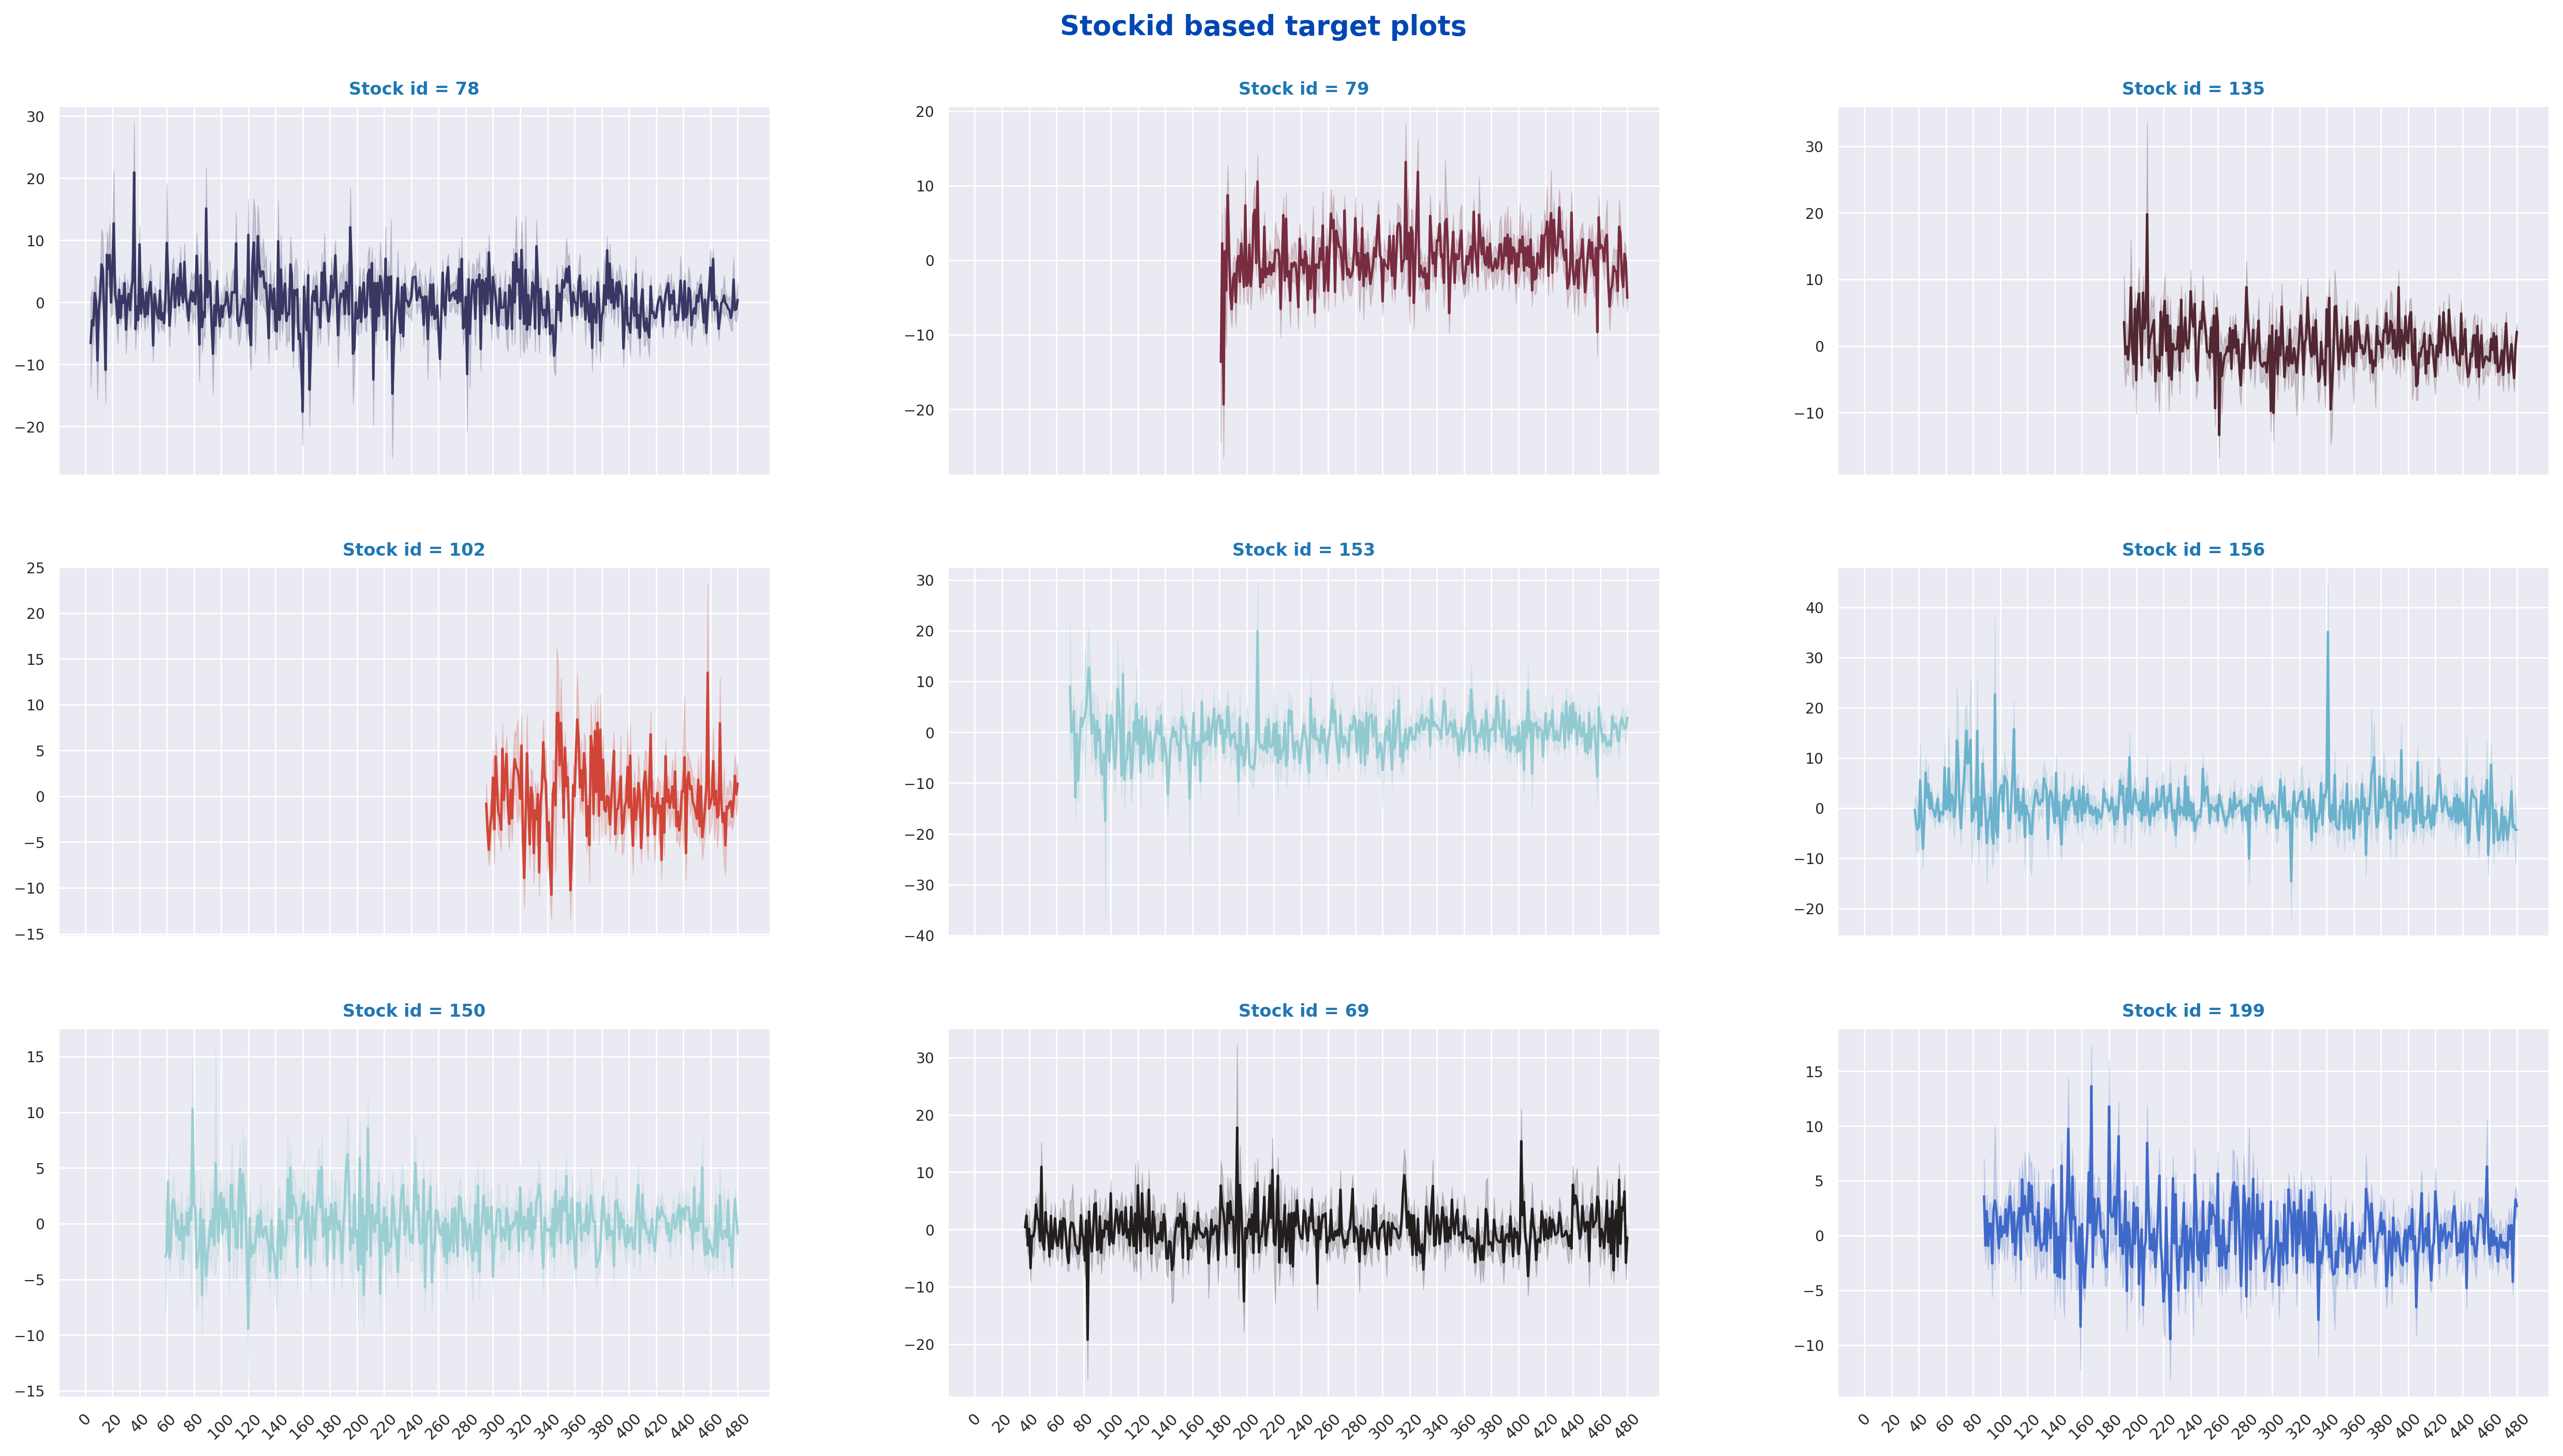


CPU times: user 1min 43s, sys: 300 ms, total: 1min 43s
Wall time: 1min 42s


In [38]:
%%time 

_ = \
df.select(['date_id', 'stock_id']).groupby(['stock_id']).\
agg([pl.col('date_id').min().alias("MinDate"),
     pl.col('date_id').max().alias("MaxDate")]
   ).filter((pl.col("MinDate") != 0) | (pl.col("MaxDate") != 480));

PrintColor(f"---> Stocks not aligning with 0-480 dates <---");
print();
print(_, end = "\n");
print();

_ = _.select(pl.col("stock_id")).to_numpy().flatten().tolist();
if CFG.test_req == "Y":
    pass;
else:
    PltStocks(df = df.filter(pl.col("stock_id").is_in(_)), nsample = _);

del _, df;

collect();
print();
libc.malloc_trim(0);
GetMemUsage(); 

<div class="alert alert-block alert-info" style = "font-family: Calibri;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 0.5px; padding: 3.5px" >
<b>Notes:-</b> <br>
1. We have 200 stock ids and 481 trading days in the train data <br>
2. All columns are numeric - <b>far and near price have 55% rows as nulls </b> <br>
3. Not all stocks are traded on all days and all time steps. All stock ids end on date id = 480 though some start late<br>
4. Outliers are present in several stock ids and need to be treated <br> 
</div>

## 1.2. Understand the features

In [17]:
def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        # .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

### 1.2.1 Order book

- **An order book** is a representation of trading intention on the market, however the market needs a buyer and seller at the same price to make the trade happen. Therefore, sometimes when someone wants to do a trade in a stock, they check the order book and find someone with counter-interest to trade with. 

- **Here we introduction some basic terminalogy for continuous trading hour order book:**

    - Bid Price: price that buyer willing to buy.
    - Ask Price: price that seller willing to sell.
    - Bid Size: Amount of shares that buyer want to buy.
    - Ask Size: Amount of shares that seller want to sell.
    - WAP：The weighted average price in the non-auction book.

$$
\frac{ {BidPrice * AskSize + AskPrice * BidSize}}{BidSize + AskSize}
$$

    
    and always Ask Price >= Bid Price.

Example

![](https://i.ibb.co/sqVfdLm/order-book-1.png)

Above picture is a demo of an Order Book,

- We can see that at a price level of 9 there are 2 shares on the **bid**, meaning the market participants are willing to **buy** 2 shares for a price of 9.

- We can also see that at a price level of 10 there is 1 share on the **ask**, meaning market participants are willing to **sell** 1 share for a price of 10.

![](https://i.ibb.co/WHMX37t/order-book-2.png)

If someone were to put in an ask of 10 shares at a price of 9, then 2 shares would be **matched**. The new best ask would be 8 shares at a price of 9, the new state of the book is displayed above.

-----

 ***WAP - Weighted Average Price***

- `wap` is always larger than `bid_price` and smaller `ask_price`.

- If `bid_size` is larger than `ask_size`, then `wap` would be closer to `ask_price`, and vice versa.

In other words, an increase in `bid_size` / `ask_size` would "push" the `wap` toward opposite direction, but `wap` would always stays in the gap between `bid_price` and `ask_price`.

**Basically, `wap` serve as a decent guess of the _fair price_ of a stock**: If the `bid_size` increase, the buyers are more aggressive

WAP in a nut shell, it's a price take bid/ask size into consideration. A fair book-based valuation must take two factors into account: the level and the size of orders.


- **Let's take a look at the following 2 scenarios:**

- **Scenario 1: More Buyer, more bid szie, therefore higher WAP**

        - bid price = 1, ask price =2, with ask size = 1, bid size = 2

$$WAP_{1} = \frac{1 * 1 + 2 * 2}{3}  = \frac{5}{3}$$

- **Scenario 2: More Seller, more ask size,  therefore lower WAP**

        - bid price = 1, ask price =2, with ask size = 2, bid size = 1


$$ WAP_{2} = \frac{1 * 2 + 2 * 1}{3}  = \frac{4}{3}$$


Remark: Note that in most of cases, during the continuous trading hours, an order book should not have the scenario when bid order is higher than the offer, or ask, order. In another word, most likely, the bid and ask should never be in cross.

- **Log Return (Continous Compound Return)**

$$ r_{t1,t2} = log(\frac{S_{t2}}{S_{t1}}) $$

Now we draw some time series plots to confirm our speculations:

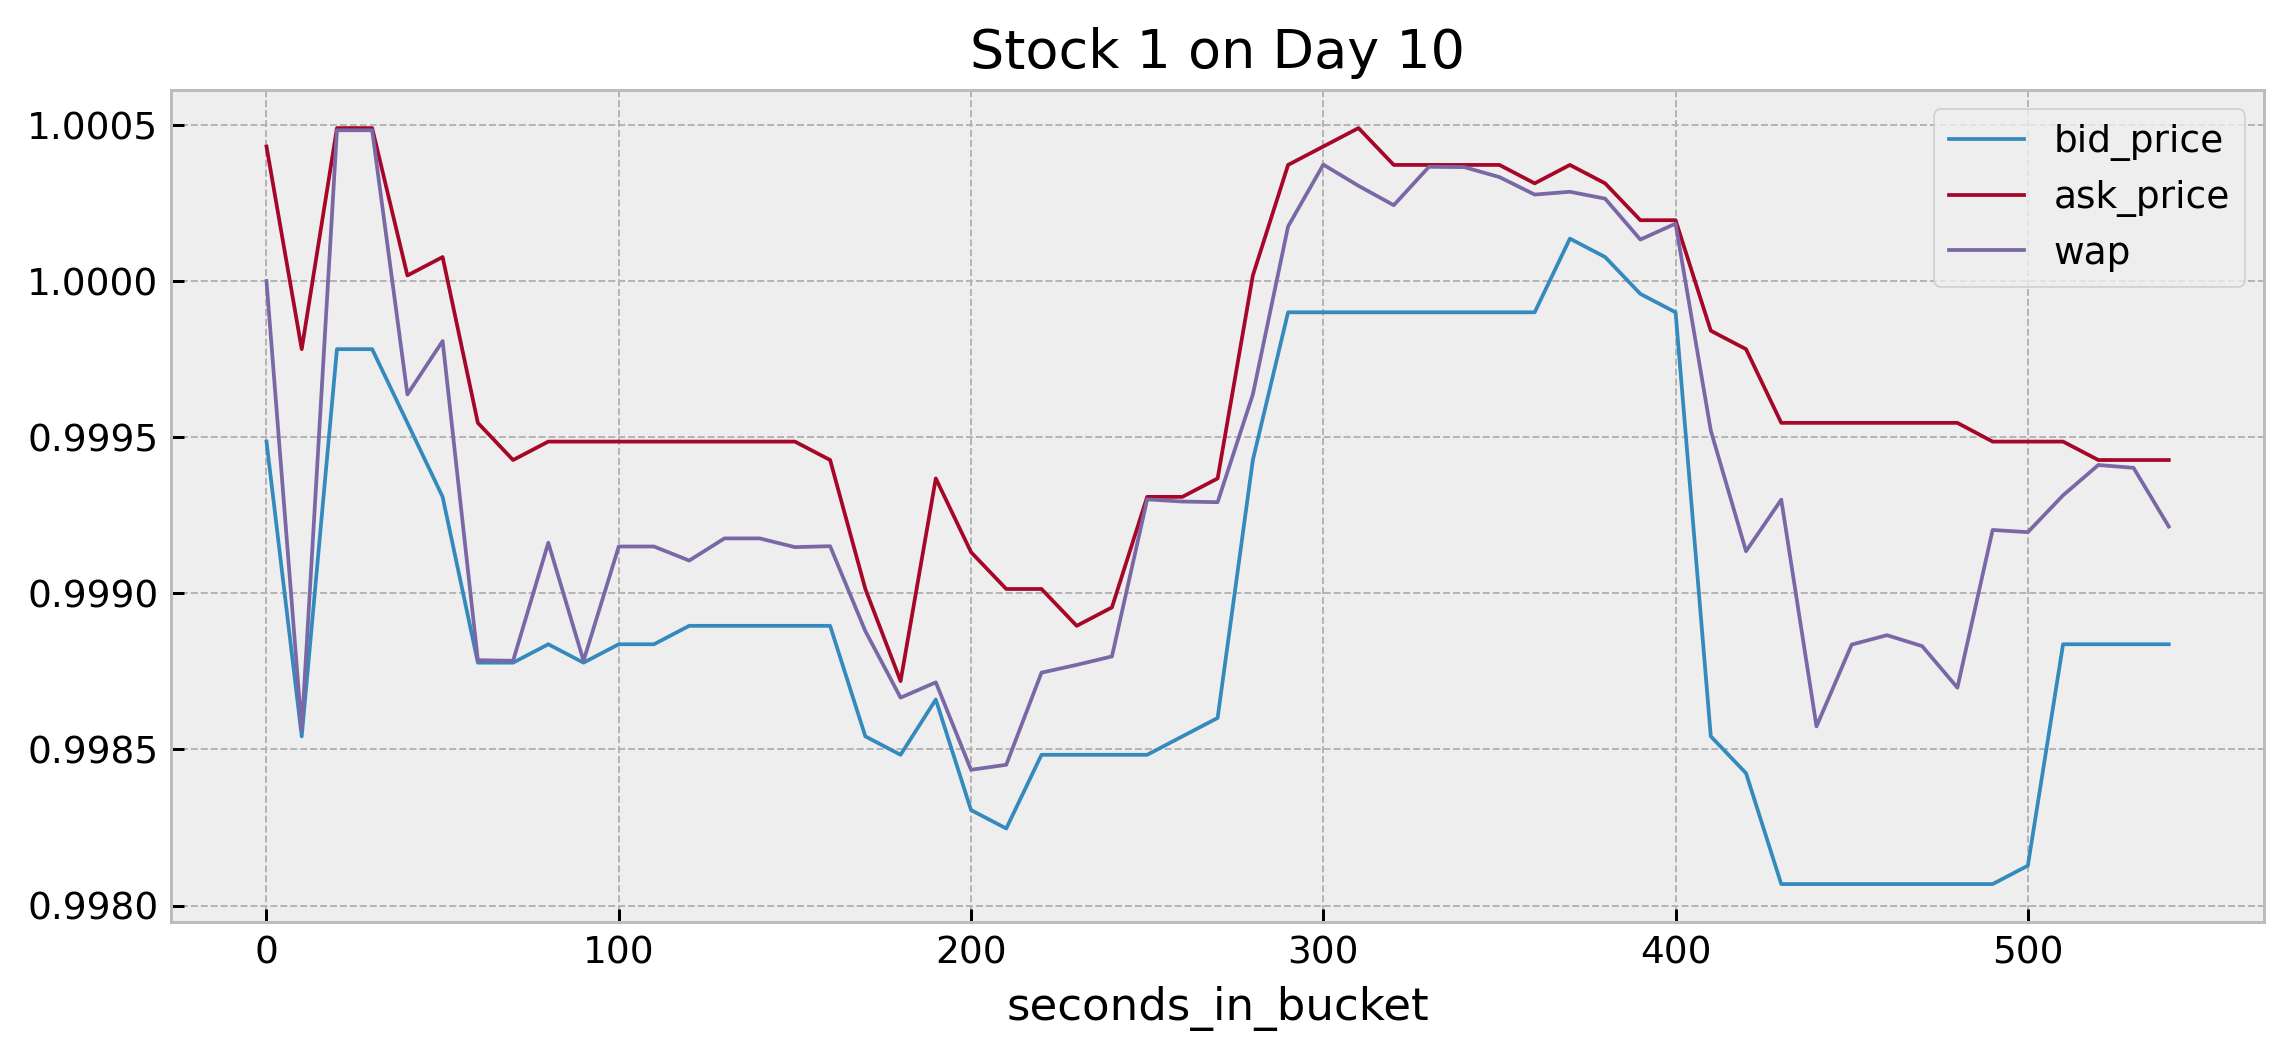

In [18]:
# We tried a few different stock_id and date_id to see the common patterns

time_series_plot(
    df=Xy_train, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 1,
    date_id = 10
)

In [5]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['wap'], 
            name = 'wap',
            line = dict(color = 'black')))

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['ask_price'], 
            name = 'ask price',
            line = dict(color = 'blue')))

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['bid_price'], 
            name = 'bid price',
            line = dict(color = 'green')))


fig.update_layout(title = "Overview for WAP",
                title_font = dict(size = 15),
                showlegend = True,
                width = 1000,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

And one more thing, all the prices shown here are converted to a price move relative to the stock `wap` (weighted average price) at the beginning of the auction period.

### 1.2.2. Auction Order Book

- #### **What is closing auction:**

    - 1.) **What is an auction?** Auction is a period of time that lets multiple buyers and sellers trade in a single price and in a single joint transaction. There are many different kinds of auction, for example London Stock Exchange offers **Opening Auction**, **Intra-Day Auction**, and **Closing Auction**. In this competition teams are particularly interested in the type of a **closing auction**.
    
    - 2.) Closing auction starts after continuous trading (Market Open session)
    
         - Take London Stock Exchange for example: 
   
            (2-1.)Opening Auction Session: 7:50 pm - 8:00 pm  
            (2-2.)Intra-Day Auction Session: 12:00 am - 12:02 am  
            (2-3.)Closing Auction Session: 16:30 am - 16:35 am  
            (2-4.)Rest of the time is regular trading hour or continous trading hour
          
    - 3.) **The closing auction** trading period is a trading mechanism with a single price bidding. Buyers and sellers enter buy and sell orders during this period. This period is also known as **call period**. After collecting the relevant orders, the trading system will determine the order that can complete the most transactions based on the interaction of the orders. This event is known as **uncrossing event**.

    - 4.) **Why do we care about the closing auction book?** In the last ten minutes of the Nasdaq exchange trading session, market makers like Optiver merge traditional **order book data** with **auction book data(Closing Auction Order Book Data)**. This ability to consolidate information from both sources is critical for providing the best prices to all market participants.
    
    - 5.) Bid & ask price of the closing auction book dataset in the call period are now **overlapping**.
    
    

- #### **Imbalance** refers to the number of unmatched shares.
    - 1.） **Imbalance_size**: The amount unmatched at the current reference price (in USD).

    - 2.） **Imbalance_buy_sell_flag**: An indicator reflecting the direction of auction imbalance.

        - buy-side imbalance: 1
        - sell-side imbalance: -1
        - no imbalance: 0
        
        
 - Remark: during my EDA process, I found that "imbalance_buy_sell_flag * imbalance_size" better reflect the information of bid/ask size.
 
- #### **Key Words Terminology with closing auction order book data**

    - 1.) **Uncorss Price**: The price which maximises the number of matched lots. In the above example will be 8.

    - 2.) **Matched Size**: the max number of matched lots by one single price. In the above example will be 4.

    - 3.) **Imbalance**: Imbalance refers to the number of unmatched shares. In the above example, the uncross price is 8 and there are 7 bids & 4 asks which can be matched for the price of 8. As a result, we have three unmatched bids remaining, and the **remaining bids** contribute to an imbalance of three lots in the **buy direction**.

- #### **More Key Words Terminology for Price Explanation:**

    - 1.) **Far Price**: The crossing price that will maximize the number of shares matched based on auction interest only. Therfore, Far price refers to the hypothetical uncross price of the auction book, if it were to uncross at the reporting time.

- #### Example
**In an Auction Order Book, the orders are not immediately matched, but instead collected until the moment the auction ends.**

![](https://i.ibb.co/HFjZQV9/order-book-3.png)

In the above example, the book is referred to as **in cross**, since the best bid and ask are overlapping.

Suppose the auction ends with the book in this state, then:

- At a price of 10, 0 lots would be matched since there as no bids >= 10.

- At a price of 9, 3 lots would be matched, as there are 3 bids >=9 and 6 asks <= 9.

- At a price of 8, 4 lots would be matched, since are 7 bids>=8, and there are 4 asks<=8.

So the price which _maximizes_ the number of matched lots would be 8. In the situation like this, We would describe the Auction Order Nook in the following way:

- The **uncross price** is 8
- The **matched size** would be 4
- There are 3 Bids (7 - 4 = 3) are still unmatched, therefore, the **imbalance** would be 3 lots in the buy direction.

At any given time, the hypothetical **uncross price** (assuming the auction ends immediately) is defined as the current **far price**. 

In other words, the **far price** is the price which _maximizes_ the number of matched lots in current status of the Auction Order Book.


- `far_price` = 8
- `matched_size` = 4 * `reference price` (we will explain `reference price` later)
- `imbalance_size` = 3 * `reference price`
- `imbalance_buy_sell_flag` = 1 (1 for buy-side imbalance, -1 for sell-side imbalance, 0 for no imbalance)

Now let's plot some time series:

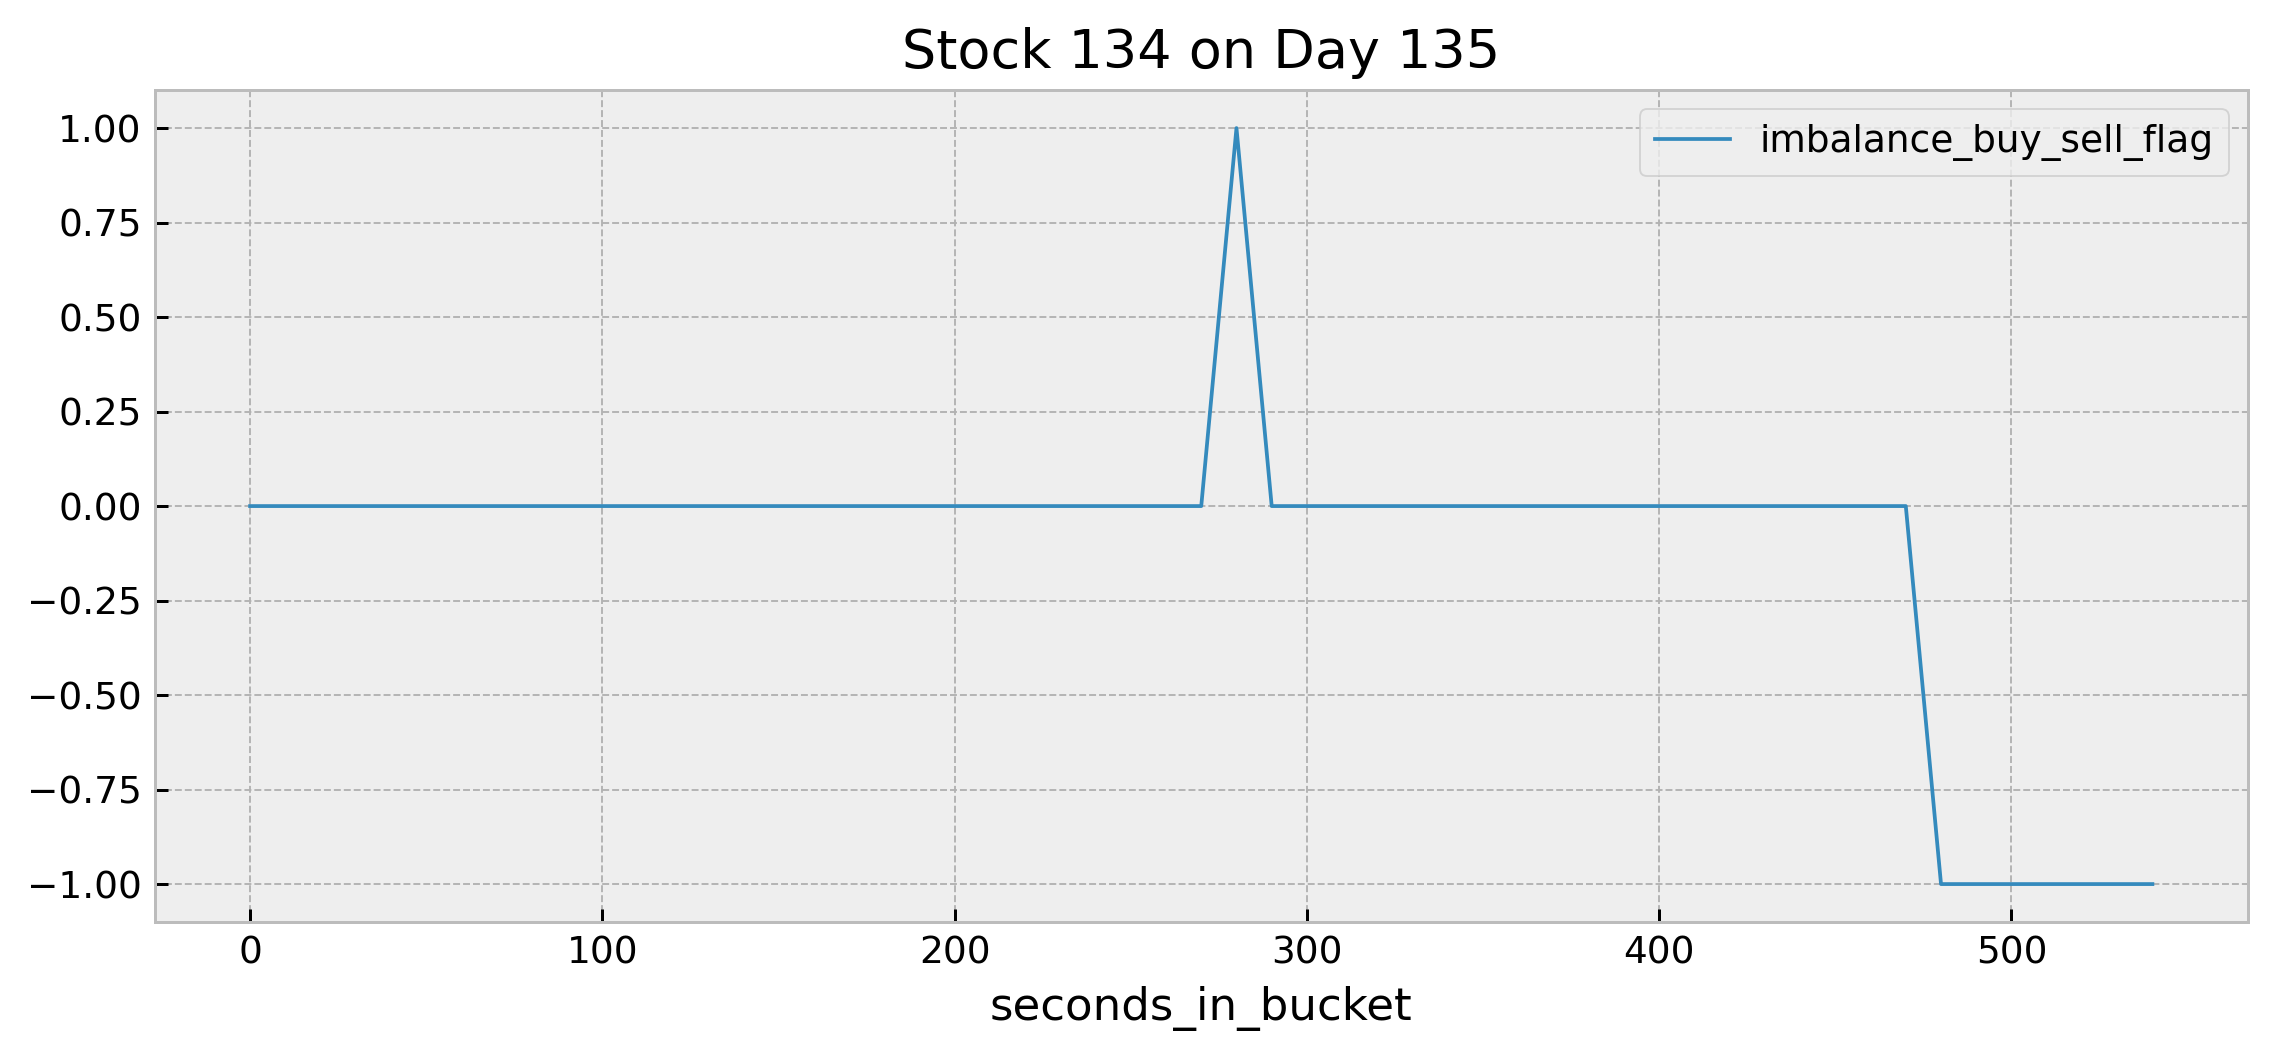

In [20]:
# To see different random stock_id and date_id, simply run the cell again
time_series_plot(
    df=Xy_train, 
    cols=['imbalance_buy_sell_flag'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

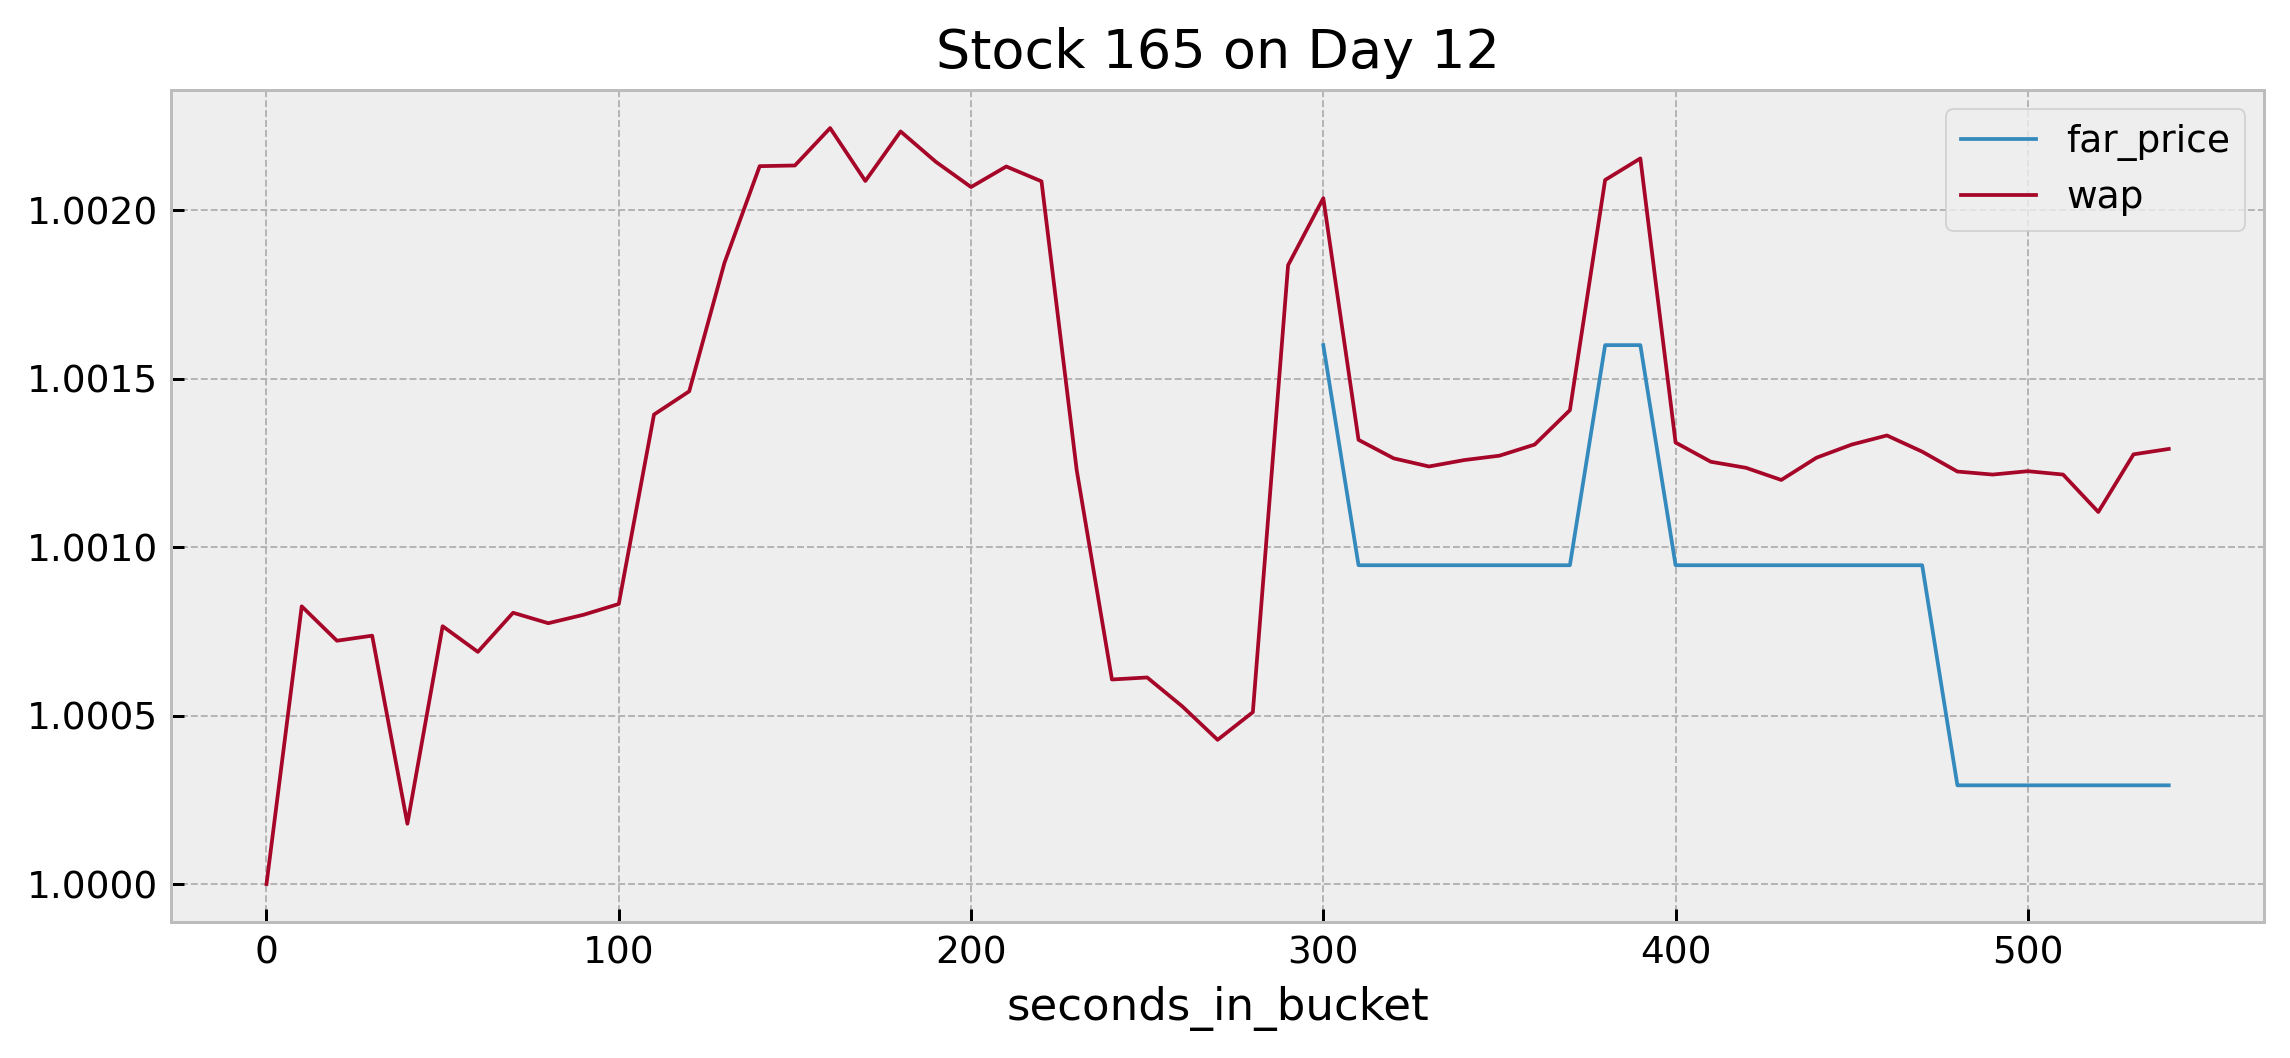

In [21]:
# Compare the far_price and wap
time_series_plot(
    df=Xy_train, 
    cols=['far_price', 'wap'],
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

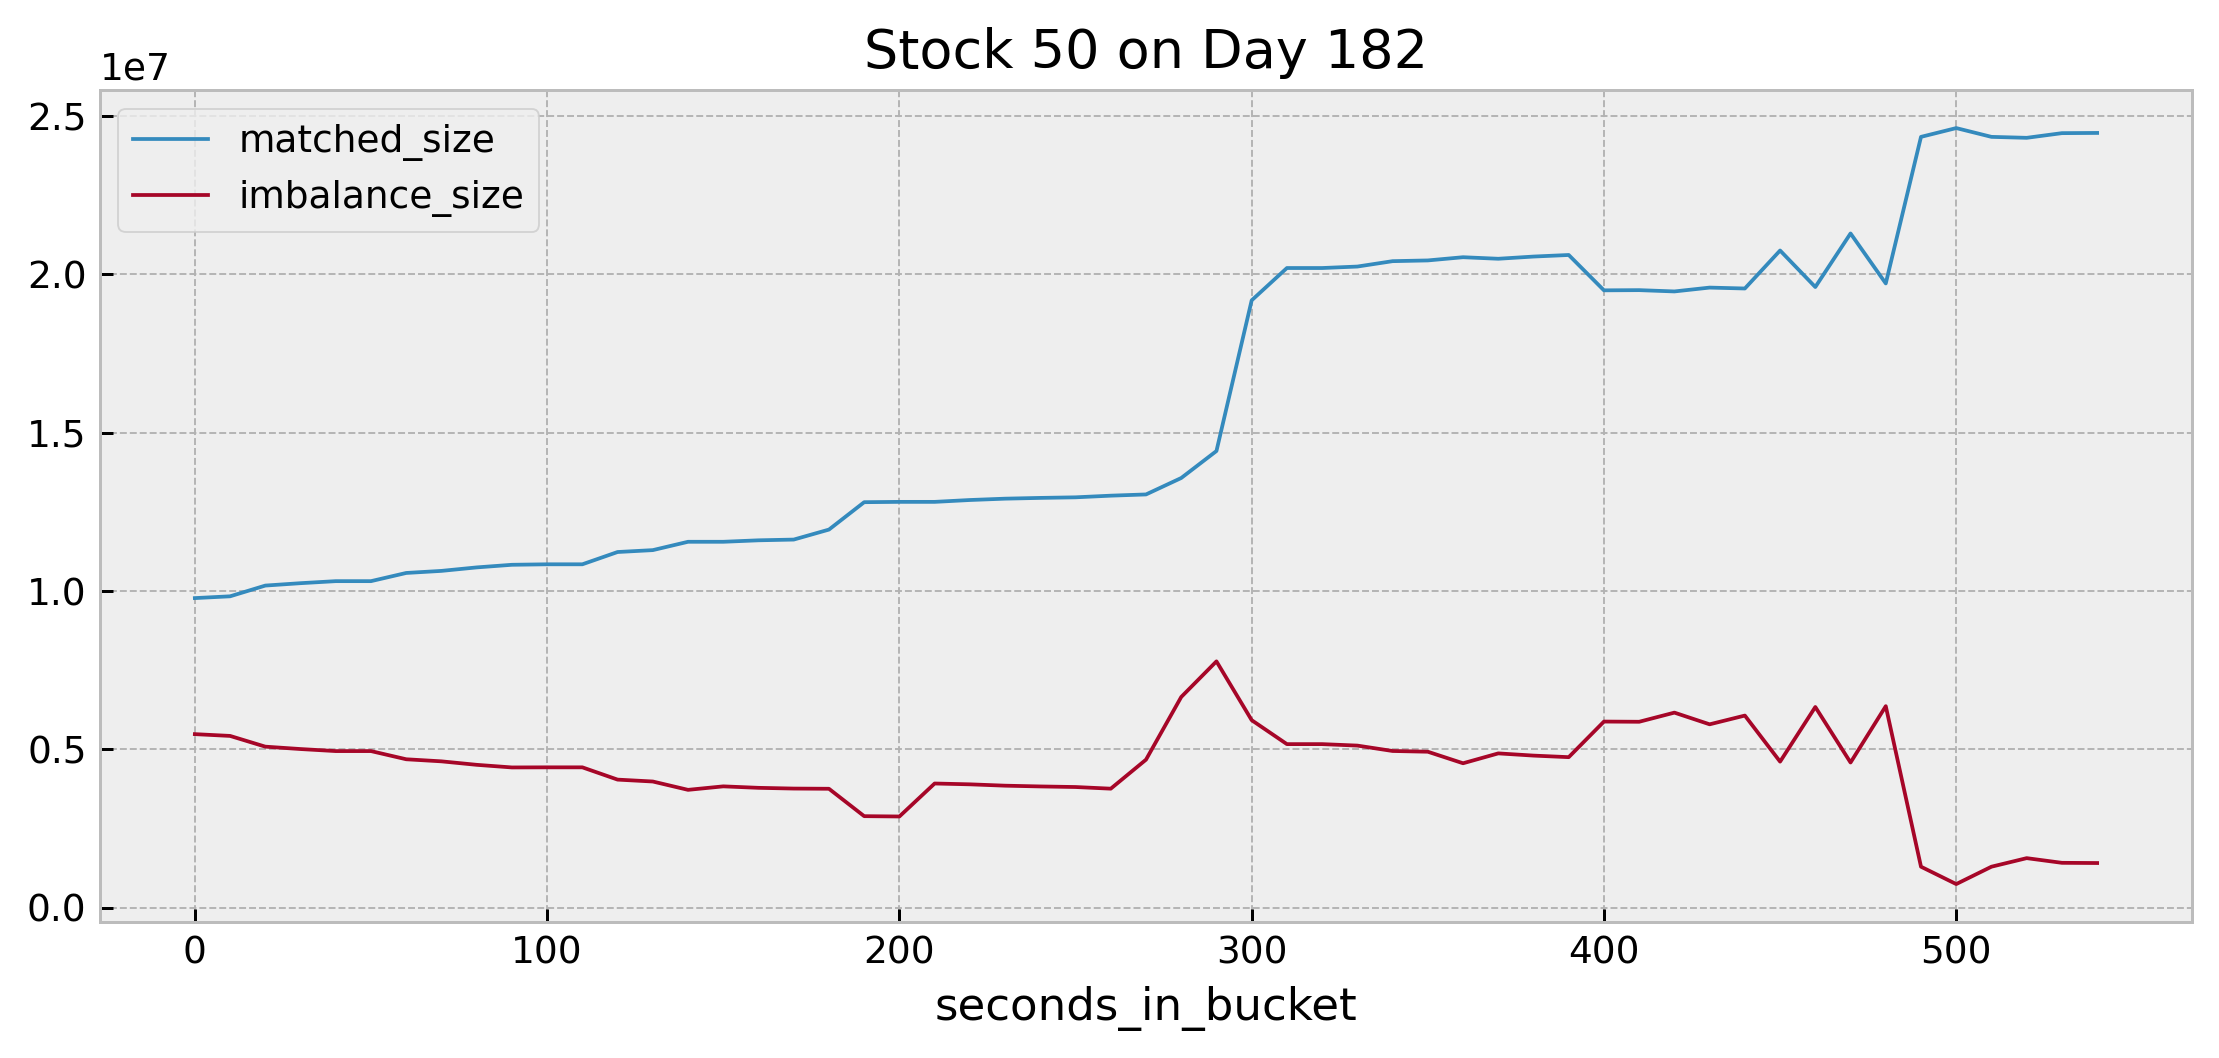

In [22]:
# Compare the matched_size and imbalance_size
time_series_plot(
    df=Xy_train, 
    cols=['matched_size', 'imbalance_size'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

After plotting the time series for different stock_id and date_id for serval times, I observe a few patterns:

- `Far Price` shows data only after `second_in_bucket`=300, which corresponds to 3:55 p.m.

- `matched_size` and `imbalance_size` significantly diverge at size, after `second_in_bucket`=240 (3:54 p.m.); `imbalance_size` tends to decrease, and `matched_size` tends to increase, after this time point.

### 1.2.3. Combined Book

Finally, the rest 2 features are related to the **Combined Book**, which is the combination of **Order Book** and **Auction Order Book**.

- 1.) **Near Price**: The crossing price that will maximize the number of shares matched **based auction** and **continuous market orders**. Nasdaq provides near price information 5 minutes before the closing cross. Therefore, in the below figure we can see that starting from 300 sec, the near price/far price start to show.

- 2.) **Reference Price**: 

        - If the "Near Price" is between the best bid and ask, then the reference price is equal to the near price

        - If the "Near Price" > best ask, then reference price = best ask

        - If the "Near Price" < best bid, then reference price = best bid So the reference price is the near price bounded between the best bid and ask. 
  ***In summary for reference price, it's a uncross price that best represent the price that will maximize the match lots in the order book data.***
        

Here we combine our previous order book example & auction book example by aggregating the buying & selling interest across all price levels.

![](https://i.ibb.co/1vPFYwz/order-book-4.png)

For this combined book:

- At a price of 10, 0 lots would be matched, as there are no bids>=10.

- At a price of 9, 5 lots would be matched, as there are 5 bids>=9 and 6 asks <=9.

- At a price of 8, 4 lots would be matched, as there are 9 bids>=8 and 4 asks <=8.

So, the price which maximizes matched lots would be the price of 9. We would therefore describe the combined order book in the following way:

- The uncross price is 9
- The matched size is 5
- The imbalance would be 1 lot, in the sell direction.

The hypothetical uncross price of combined book is called the **near price**. 

Same as the **far price**, Nasdaq provides **near price** 5 minutes before the closing cross (3:55 p.m.).


Now let's put the `bid_price`, `ask_price`, `wap`, `far_price`, `near_price`, and `reference_price` together:

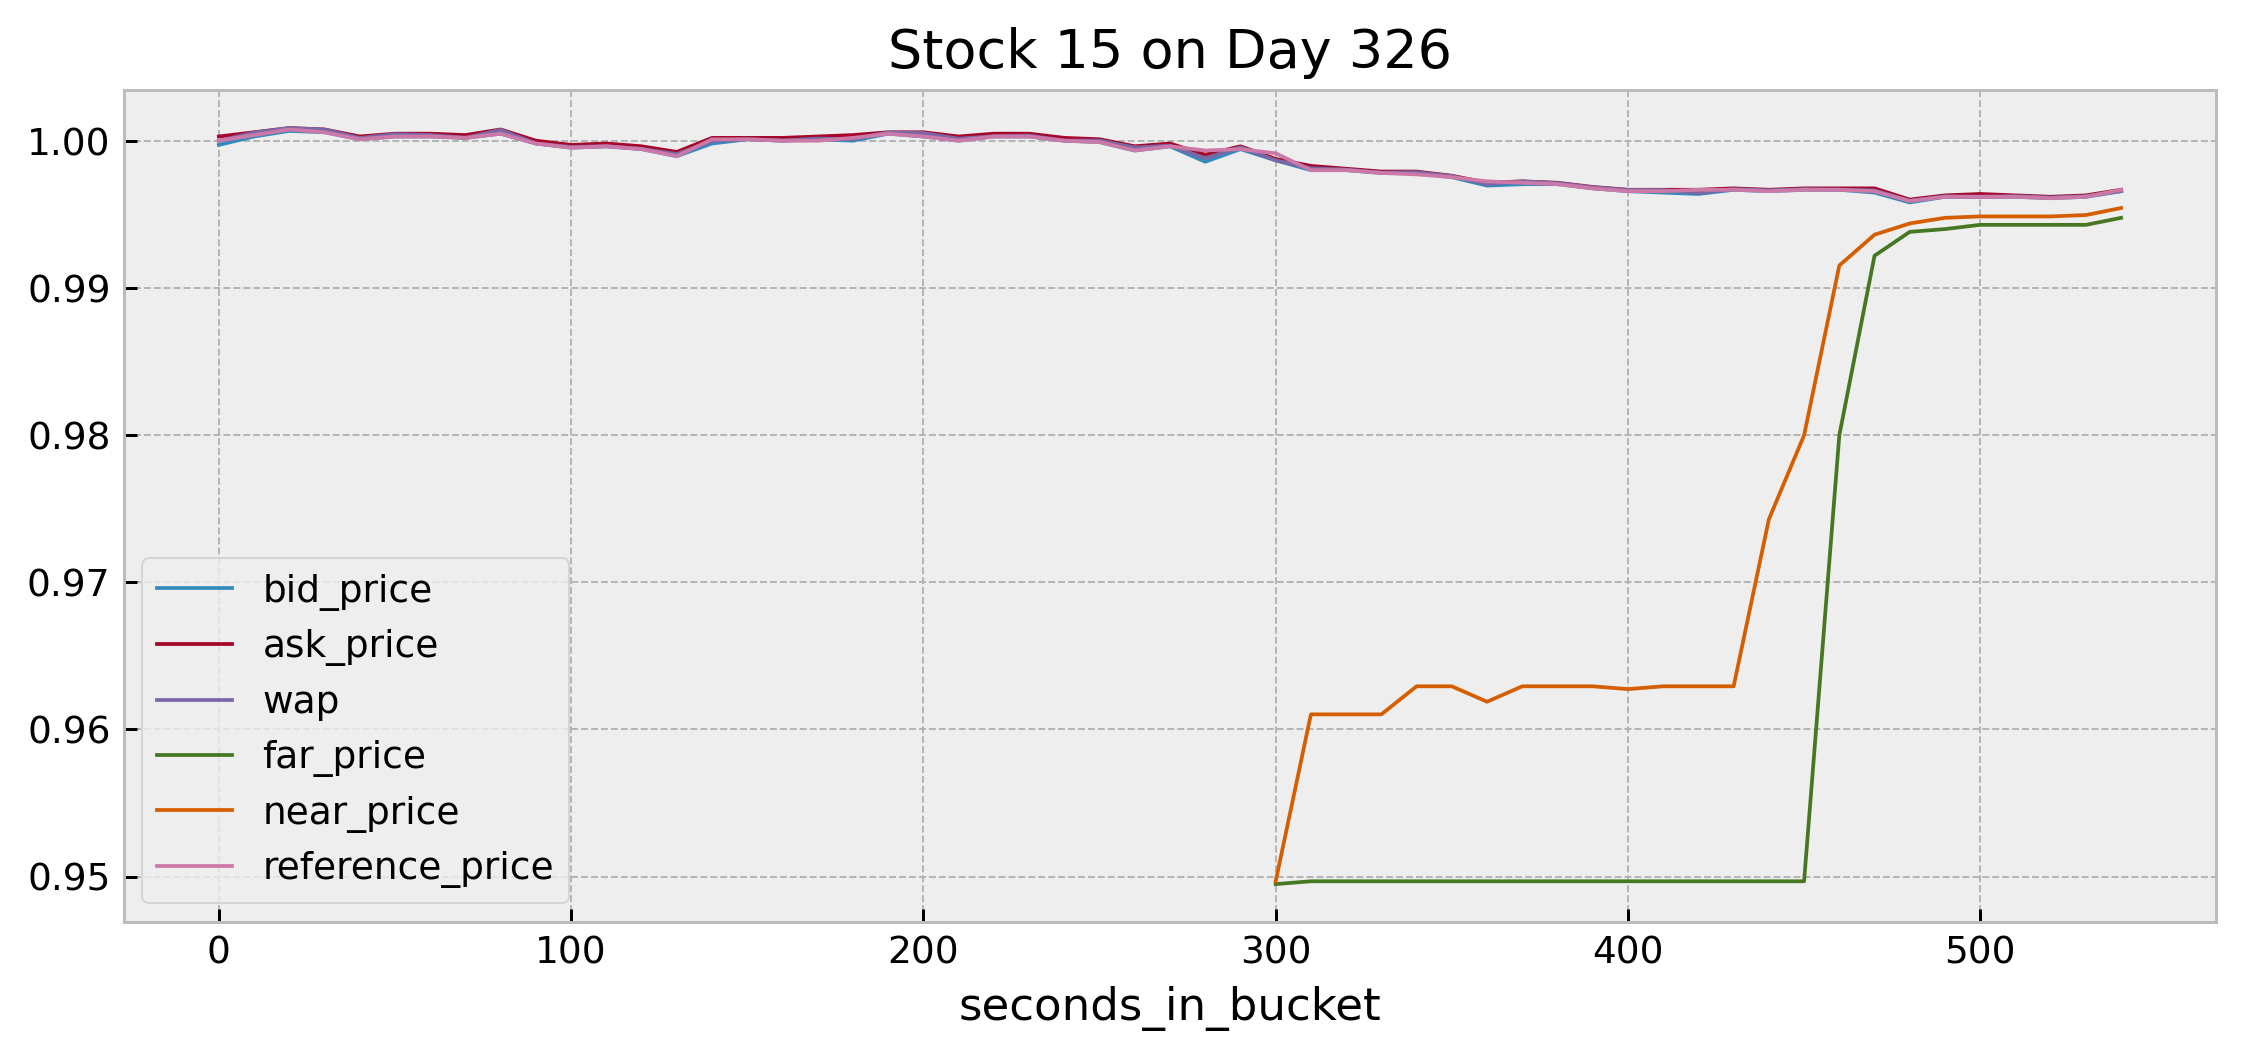

In [23]:
time_series_plot(
    df=Xy_train, 
    cols=['bid_price', 'ask_price', 'wap', 'far_price', 'near_price', 'reference_price'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

Finally, according to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data), all price related columns are converted to a price move relative to the stock `wap` at the beginning of the auction period. 

In other words, the `wap` should be 1 for all beginnings of our Time Series. Let's verify this programatically.

In [24]:
# Find all wap not equal 1 when seconds_in_bucket == 0
Xy_train.query("seconds_in_bucket == 0").query('wap != 1')

stock_id  date_id  seconds_in_bucket  imbalance_size  \
369508        131       35                  0             NaN   
3555081       101      328                  0             NaN   
4215138       158      388                  0             NaN   
4764999        19      438                  0             NaN   

         imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
369508                     0                  NaN           NaN        NaN   
3555081                    0                  NaN           NaN        NaN   
4215138                    0                  NaN           NaN        NaN   
4764999                   -1                  NaN           NaN        NaN   

         near_price  bid_price  bid_size  ask_price  ask_size  wap  target  \
369508          NaN        NaN       0.0        NaN       0.0  NaN     NaN   
3555081         NaN        NaN       0.0        NaN       0.0  NaN     NaN   
4215138         NaN        NaN       0.0        NaN       0.0  NaN     NaN   
4764999         NaN        NaN       0.0        NaN       0.0  NaN     NaN   

         time_id     row_id  
369508      1925   35_0_131  
3555081    18040  328_0_101  
4215138    21340  388_0_158  
4764999    24090   438_0_19

## 1.3 Understand the target (WAP)

> According to the [Dataset Description](https://www.kaggle.com/competitions/optiver-trading-at-the-close/data), `target` is the 60 second future move in the `wap` of the stock, less the 60 second future move of the synthetic index.

- **Target Variable Formula**:

$$ Target = (\frac{WAP_{t+60}}{WAP_{t}} - \frac{Index_{t+60}}{Index_{t}})$$

Therefore, I think we can only use the stock information to predict the target


- **Remark**:

    1.) The benchmark synthetic index  = The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.

    2.) The unit of the target is basis points, which is a common unit of measurement in financial markets.  A 1 bp price move is equivalent to a 0.01% price move.

In [25]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['target'], 
            name = 'Target variable',
            line = dict(color = 'red'),
            yaxis = "y2"))

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['wap'], 
            name = 'WAP',
            line = dict(color = 'black')))

fig.update_layout(title = "Overview for WAP and Target Variable",
                title_font = dict(size = 15),
                showlegend = True,
                width = 1000,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20),
                yaxis2 = dict(title = "Target Variable", overlaying = "y", side = "right"),)

From the above chart, you can definitely see that the target variable contains information of the WAP!!

<div class="alert alert-block alert-info" style = "font-family: Calibri;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 0.5px; padding: 3.5px" >
<b>Notes:-</b> <br>
1. One may choose to plot candle-stick plots using Open, close, high and low prices across stocks and dates. <br>
2. All information for the below plots are sourced from plotly official documents- <a>https://plotly.com/python/<\a> <br>
3. Inferences are very similar to the price and volume plots from prior cells. <br>
</div>

In [41]:
%%time 

# Collating the Open-High-Low-Close prices across stocks and dates:-
df = \
X.select(['date_id', 'stock_id', 'seconds_in_bucket', 'wap', 'matched_size']).\
group_by(['date_id', 'stock_id']).\
agg([pl.col('wap').first().alias("Open"),
     pl.col('wap').max().alias("High"),
     pl.col('wap').min().alias("Low"),
     pl.col('wap').last().alias("Close"),
     (pl.col('matched_size').sum()/1_000_000).alias("TotMatchVolMil")
]).\
sort(by = ['stock_id','date_id'], descending = [False, False]).\
collect();

df.write_csv(f"OHLC_Sum_V{CFG.version_nb}.csv");

CPU times: user 3.03 s, sys: 788 ms, total: 3.82 s
Wall time: 1.24 s


In [40]:
%%time 

# Plotting a random sample of stock id candlesticks:-
stock_ids = np.random.randint(0, 200, 2);

for i in stock_ids:
    _ = df.filter(pl.col("stock_id") == i);
    candlesticks = \
    Candlestick(x     = _['date_id'],
                open  = _['Open'],
                high  = _['High'],
                low   = _['Low'],
                close = _['Close'],
                showlegend =False,
               );

    volume_bars = \
    Bar(x = _['date_id'], y = _['TotMatchVolMil'], showlegend = False, marker = {"color": "rgba(128,128,128,0.5)",});

    fig = Figure(candlesticks);
    fig = make_subplots(specs=[[{"secondary_y": True}]]);
    fig.add_trace(candlesticks, secondary_y=True);
    fig.add_trace(volume_bars, secondary_y=False);
    fig.update_layout(height = 600, font_color = "blue",
                      title = {'text': f"Stock {i} OHLC", 
                               'y': 0.92, 
                               'x':0.5, 
                               'xanchor': 'center',
                               'yanchor': 'top', 
                               'font_family': "Arial", 
                               "font_color": "blue"
                              },
                      xaxis = dict(tickmode = 'linear',tick0 = 0, dtick = 10, tickangle = -90),
                     );
    fig.update_yaxes(title = "Price", secondary_y=True, showgrid= True);
    fig.update_yaxes(title = "MatchedVolumeMil", secondary_y=False, showgrid= False);
    fig.show();
    del _;

del df;

collect();
print();
PrintColor(GetMemUsage(), color = Fore.RED); 


RAM usage = 1.555 GB
CPU times: user 347 ms, sys: 37 ms, total: 384 ms
Wall time: 586 ms


# ***2. Extensive EDA***

## ***2.1 Correlation of Features***

In [26]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import display_html, clear_output;

!pip install -q --upgrade scipy;

clear_output();
print();
collect();


CPU times: user 2.28 s, sys: 438 ms, total: 2.72 s
Wall time: 2min 39s


In [27]:
%%time
from warnings import filterwarnings;
filterwarnings('ignore');
# General library imports:-
from os import path, walk, getpid;
from psutil import Process;

from copy import deepcopy;
import pandas as pd;
import numpy as np;
import polars as pl;
import polars.selectors as cs;

import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from plotly.graph_objects import Candlestick, Bar, Figure;
from plotly.subplots import make_subplots;

from pprint import pprint;
import ctypes;
libc = ctypes.CDLL("libc.so.6");

print();
collect();
clear_output();

CPU times: user 202 ms, sys: 26 ms, total: 228 ms
Wall time: 563 ms


In [29]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing :-   
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Tracking kernel memory usage:-  
def GetMemUsage():
    """
    This function defines the memory usage across the kernel. 
    Source-
    https://stackoverflow.com/questions/61366458/how-to-find-memory-usage-of-kaggle-notebook
    """;
    
    pid = getpid();
    py = Process(pid);
    memory_use = py.memory_info()[0] / 2. ** 30;
    return f"RAM usage = {memory_use :.4} GB";

# Display adjacent tables for easy viewing:-
def DisplayAdjTbl(*args):
    """
    This function displays pandas tables in an adjacent manner, sourced from the below link-
    https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """;
    
    html_str=''
    for df in args: html_str+= df.to_html();
    display_html(html_str.replace('table','table style="display:inline"'), raw=True);
    
# Defining formatting class for thousands and millions for axis units:-
class AxisFormatter():
    """
    This class creates axis formats for the user-defined units
    """;
    
    def __init__(self, units: int):
        self.units = 1 if units < 1 else units;
    
    def MakeFmt(self, x, pos):
        """
        This method maps the formatting string based on the units specified.
        The two args are the value and tick position
        Source - https://matplotlib.org/3.4.3/gallery/ticks_and_spines/custom_ticker1.html
        """;
        
        self.fmtmapper = {1000: "T", 1e6: "M", 100: "H"};
        return f"{x / self.units :.1f}{self.fmtmapper.get(self.units, '')}";
        
# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

# Setting global configurations for polars:-
pl.Config.activate_decimals(True).set_tbl_hide_column_data_types(True);
pl.Config(**dict(tbl_formatting = 'ASCII_FULL_CONDENSED',
                 tbl_hide_column_data_types = True,
                 tbl_hide_dataframe_shape = True,
                 fmt_float = "mixed",
                 tbl_cell_alignment = 'CENTER',
                 tbl_hide_dtype_separator = True,
                 tbl_cols = 100,
                 tbl_rows = 100,
                 fmt_str_lengths = 100,
                )
         );



CPU times: user 155 ms, sys: 874 µs, total: 156 ms
Wall time: 154 ms


In [32]:
class CFG:
    "This is a parameter configuration class for the code";
    
    # Data preparation:-   
    version_nb         = 1;
    test_req           = "N";
    test_frac          = 1000;
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = 'target';
    path               = f"/kaggle/input/optiver-memoryreduceddatasets/";
    df_lbl             = f"XTrainIntCmp.parquet";
    
    # Controls for plots:-
    tgt_plt_req        = "Y";
    
    # Global variables for plotting:-
    grid_specs     = {'visible': True, 'which': 'both', 'linestyle': '--', 
                      'color': 'lightgrey', 'linewidth': 0.75
                     };
    title_specs    = {'fontsize': 9, 'fontweight': 'bold', 'color': 'tab:blue'};
    suptitle_specs = {'fontsize': 14, 'fontweight': 'bold', 'color': '#0047b3'};
    
PrintColor(f"Configuration complete!");
     

Configuration complete!


<div class="alert alert-block alert-info" style = "font-family: Calibri;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 0.5px; padding: 3.5px" >
We will use Polars for data wrangling, making use of its lazy execution and speed of execution all along <br>
Considering the large size of the data, we will not read the files, but conduct lazy execution only to the extent of information necessary
</div>

In [35]:
%%time 

# Importing datasets:-
y = pl.scan_parquet(CFG.path + "Ytrain.parquet").rename({'__index_level_0__': 'index'});
X = pl.scan_parquet(CFG.path + CFG.df_lbl).rename({'__index_level_0__': 'index'});
strt_ftre = X.columns[0:-1];
X = X.join(y, on = "index");

# PrintColor(f"\nStarting features\n");
# pprint(strt_ftre, depth = 1, indent = 5);

# PrintColor(f"\nAll features in table X\n");
# pprint(X.columns, depth = 1, indent = 5);

# Collating nulls in several price columns into a common dataframe:-
X.filter(pl.col("imbalance_size").is_null()).collect().write_csv(f"Nulls_df.csv",)


CPU times: user 1.85 s, sys: 411 ms, total: 2.26 s
Wall time: 633 ms


In [36]:
%%time 

# Considering basic information regarding the features:-
df = X.select(['stock_id','date_id', 'time_id', CFG.target]).collect();
PrintColor(f"---> " + GetMemUsage() + '\n', color = Fore.RED);

PrintColor(f"---> Overall training data length = {df.shape[0]:,.0f} rows without target = null values\n");

for col in ['stock_id','date_id', 'time_id']:
    PrintColor(f"---> {col.upper()} analysis\n");
    display(df.select(pl.col(col)).describe().\
            to_pandas().\
            set_index("describe").transpose().\
            style.format(precision = 2)
           );
    
    PrintColor(f"\n---> {col.upper()} analysis by target variable counts\n");
    display(df.groupby([col]).agg(pl.col(CFG.target).count().alias("Size")).select(["Size"]).\
            describe(percentiles = [0.01, 0.05, 0.5, 0.90, 0.95, 0.99]).\
            to_pandas().set_index("describe").T.\
            style.format(formatter = '{:,.2f}').\
            background_gradient(cmap = "Pastel1", axis=1)
           );
    print();
    
print();
collect();
libc.malloc_trim(0);
PrintColor(GetMemUsage());

---> RAM usage = 1.59 GB

---> Overall training data length = 5,237,892 rows without target = null values

---> STOCK_ID analysis




---> STOCK_ID analysis by target variable counts




---> DATE_ID analysis




---> DATE_ID analysis by target variable counts




---> TIME_ID analysis




---> TIME_ID analysis by target variable counts





RAM usage = 1.606 GB
CPU times: user 3.18 s, sys: 834 ms, total: 4.02 s
Wall time: 1.57 s


---> Plotting 6 stock ids sample integer


Target line plots: 0it [00:00, ?it/s]

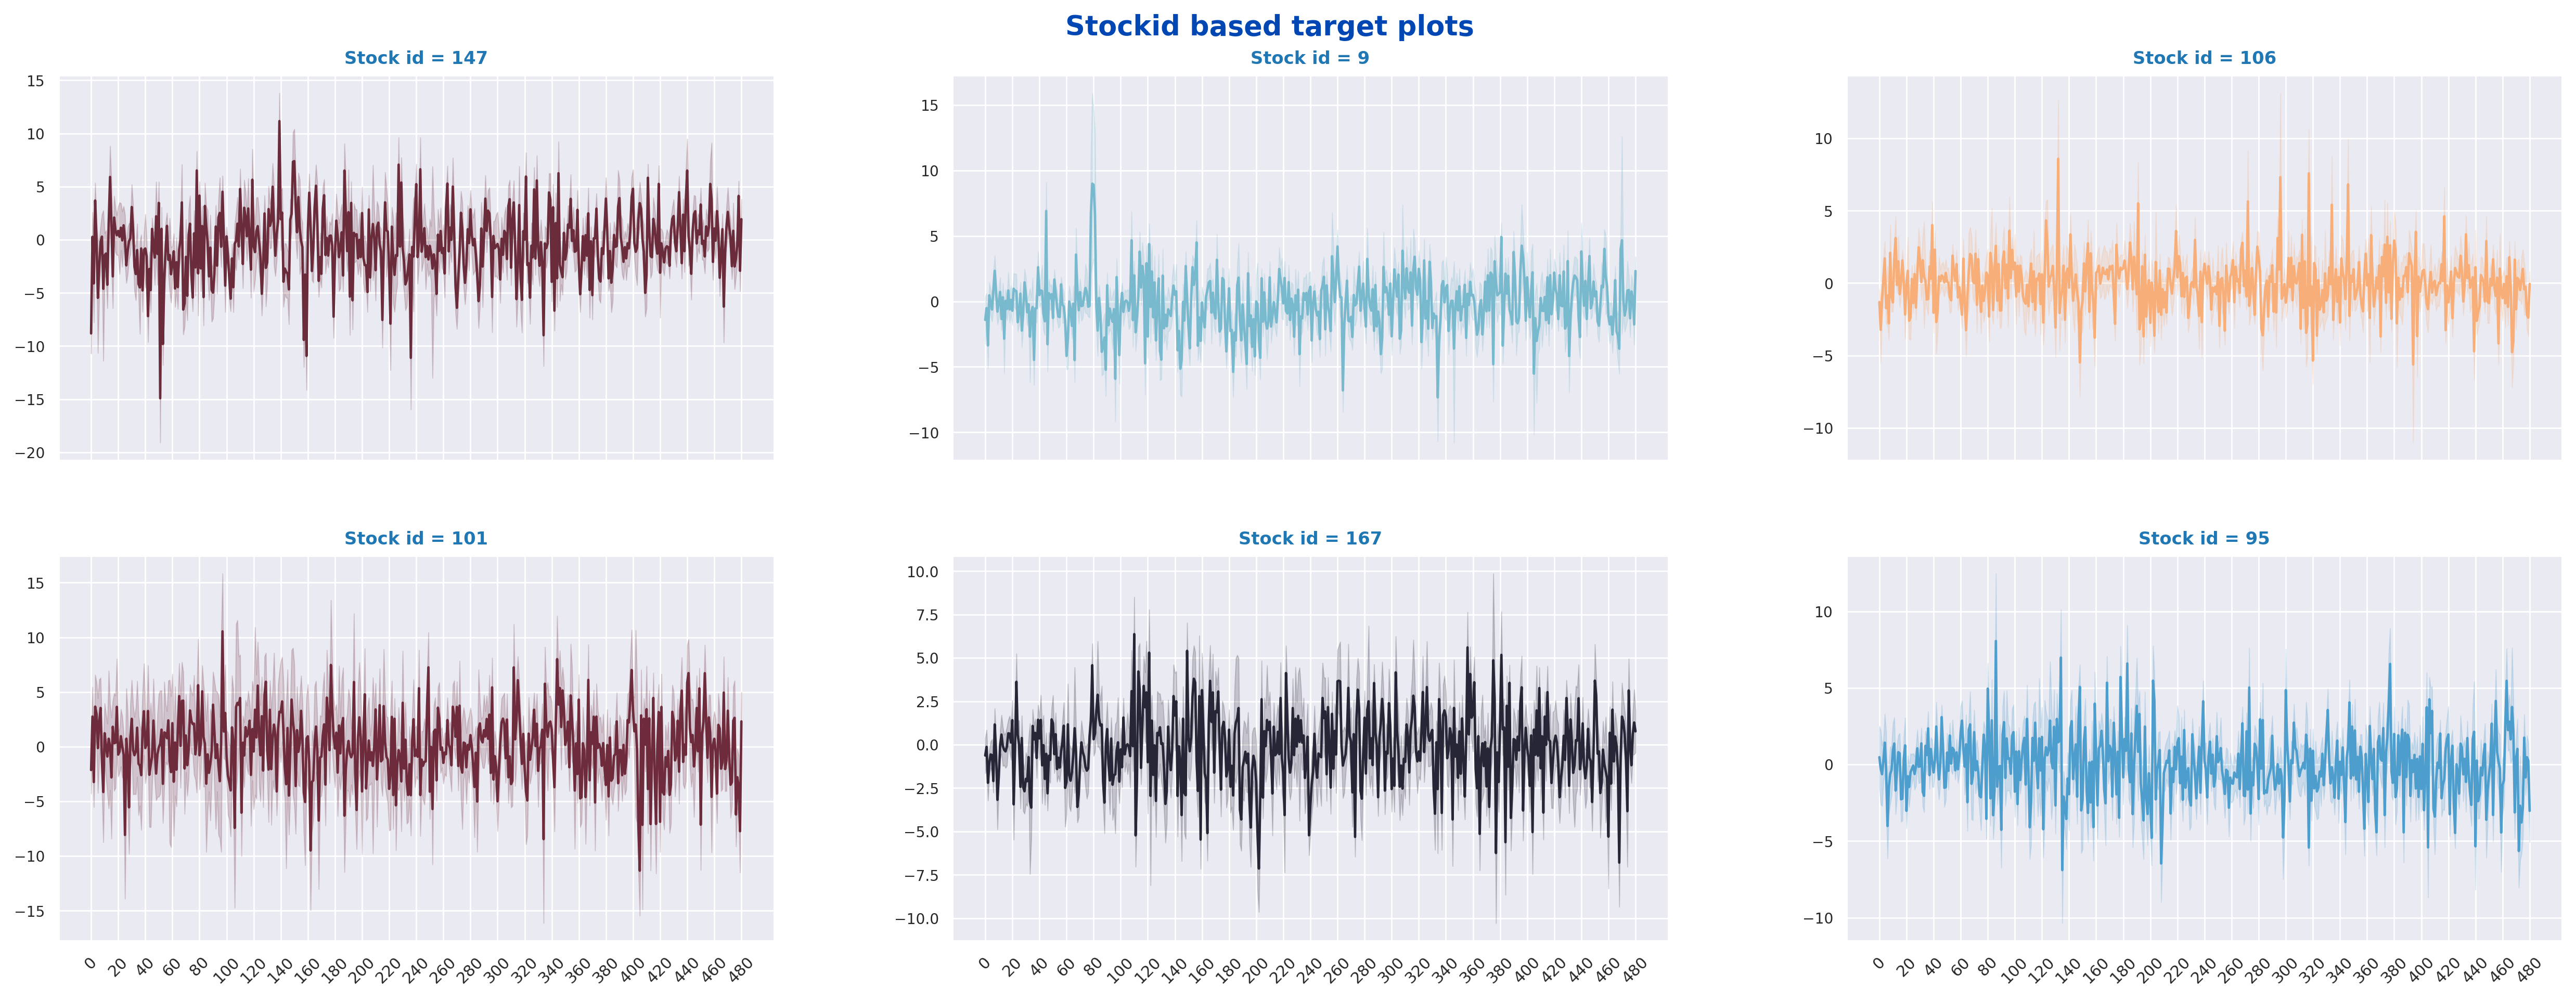


CPU times: user 1min 27s, sys: 302 ms, total: 1min 28s
Wall time: 1min 27s


In [37]:
%%time 

def PltStocks(nsample, df: pl.DataFrame):
    """
    This function plots the target versus stock ids as per the user's choice
    One may plot all stock ids/ sampled ids only
    """;
    
    ncols = 3;
    
    if isinstance(nsample, list):
        PrintColor(f"---> Plotting stock ids sample list", color = Fore.MAGENTA);
        nsamples = deepcopy(nsample);
        nrows = np.uint8(np.ceil(len(nsample)/ncols));
    elif(isinstance(nsample, int)):
        nsample = max(4, min(200, nsample));
        if nsample == 200:
            PrintColor(f"---> Plotting all stock ids");
            nsamples = range(0, 200);
        else:
            PrintColor(f"---> Plotting {nsample} stock ids sample integer", 
                       color = Fore.MAGENTA);
            nsamples = np.random.randint(0, 199, size = nsample);
        nrows  = np.uint8(np.ceil(nsample/ ncols));
    
    colors = sns.color_palette('icefire', 200).as_hex();
    
    fig, axes = plt.subplots(nrows, ncols, figsize = (23, 4 * nrows), 
                             gridspec_kw = {"hspace": 0.25, "wspace": 0.25},
                             sharex = True,
                            ); 
    
    for i, stock_id in tqdm(enumerate(nsamples), f"Target line plots"):
        ax = axes[i//ncols, i % ncols];
        d = \
        df.select(['stock_id','date_id', CFG.target]).\
        filter(pl.col('stock_id') == stock_id).drop(['stock_id']);
        sns.lineplot(x = d["date_id"], y= d[CFG.target],
                     **{'linewidth': 1.25, "c": colors[np.random.randint(len(colors))]}, 
                     ax = ax,
                    );
        ax.set(xlabel = "", ylabel = "");
        ax.set_title(f"Stock id = {stock_id}", **CFG.title_specs);
        ax.set_xticks(ticks    = np.int16(np.arange(0, 481, 20)),
                      labels   = np.int16(np.arange(0, 481, 20)), 
                      fontsize = 8, rotation = 45
                     );
        del d;
        collect();   
        
    plt.tight_layout();
    plt.xticks(np.int16(np.arange(0, 481, 20)), fontsize = 8, rotation = 45);
    plt.suptitle(f"Stockid based target plots\n", y= 0.935, **CFG.suptitle_specs);
    plt.show();  
    
# Implementing the plotting function:-
if CFG.tgt_plt_req == "Y" and CFG.test_req != "Y": 
    PltStocks(df= df, nsample = 6);

collect();
print();
libc.malloc_trim(0);
GetMemUsage(); 
    

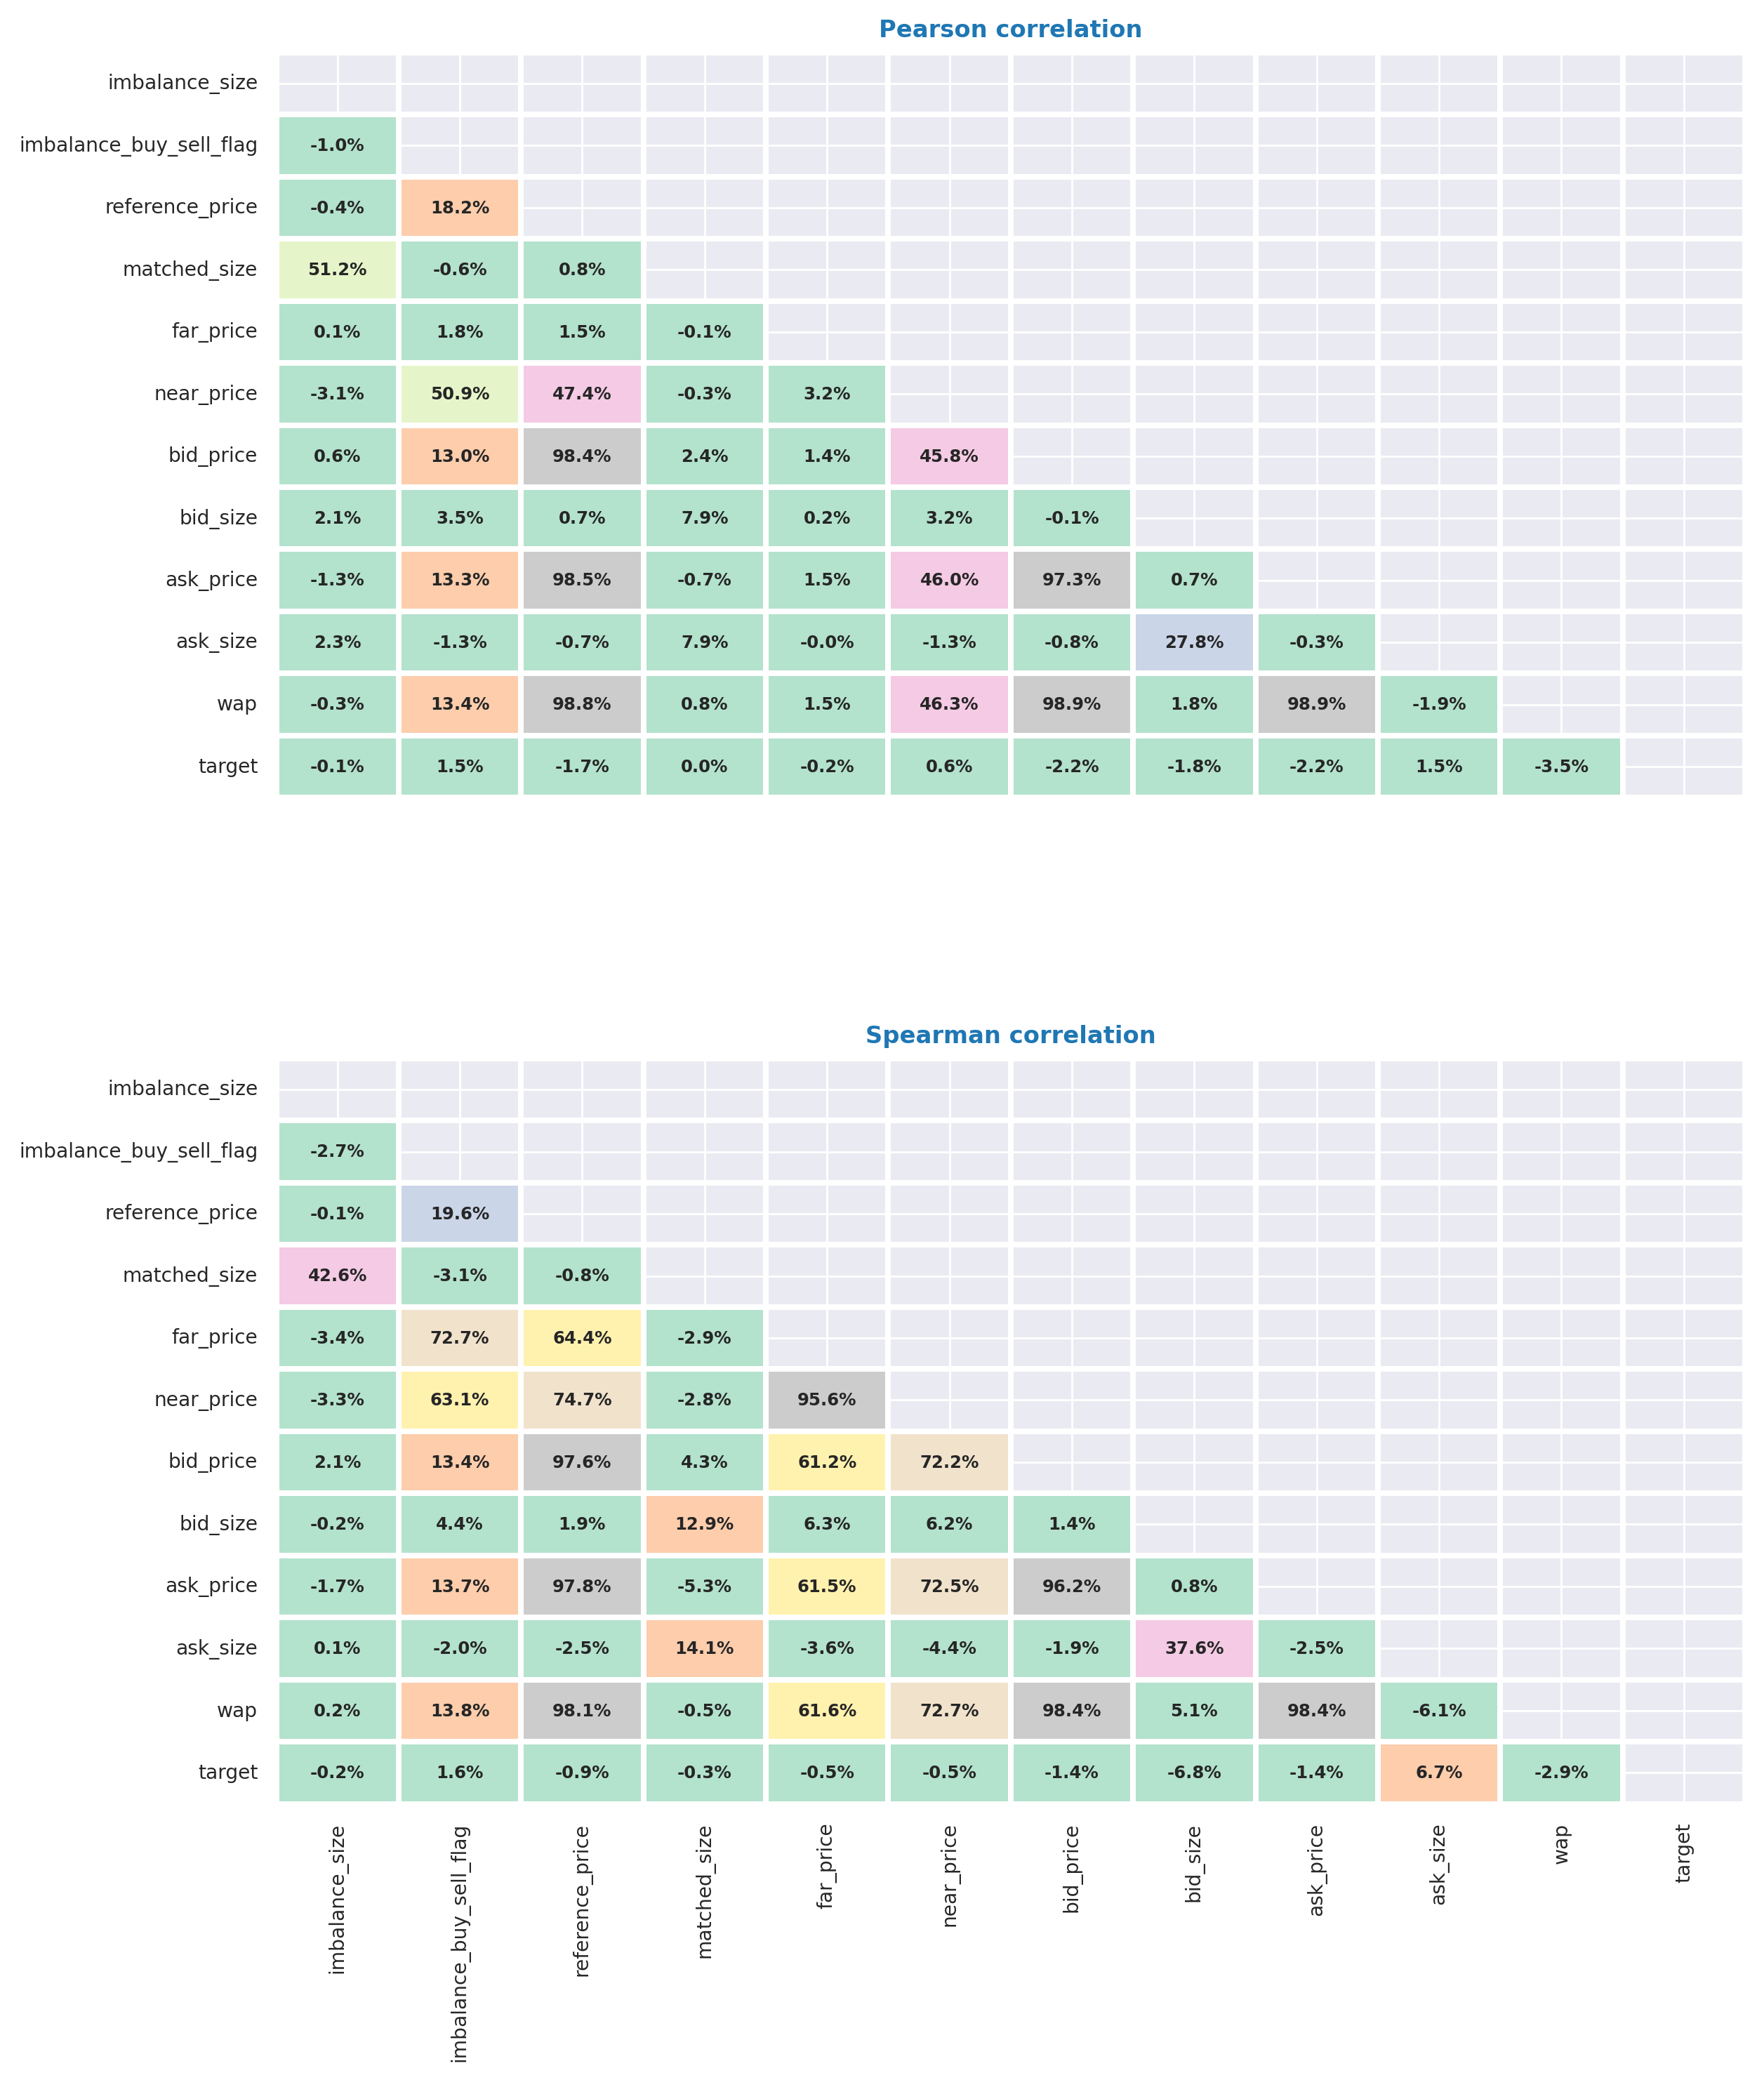

RAM usage = 2.06 GB
CPU times: user 1min 31s, sys: 3.77 s, total: 1min 35s
Wall time: 1min 27s


In [42]:
%%time 

fig, axes = plt.subplots(2,1, figsize = (10, 12), 
                         gridspec_kw = {"hspace": 0.35, "wspace": 0.35},
                        sharex = True
                        );

for i, method in enumerate(['pearson', 'spearman']):
    ax = axes[i];
    corr_ = \
    X.drop(['date_id', "stock_id","seconds_in_bucket", "time_id", "index"]).\
    collect().\
    to_pandas().\
    corr(method = method);
    
    sns.heatmap(corr_, cbar = False, annot = True, fmt = '.1%', 
                cmap = "Pastel2", linewidth = 2.0, linecolor = "white", 
                annot_kws = {"fontsize": 6.5, "fontweight": "bold"},
                mask = np.triu(np.ones_like(corr_)), 
                ax = ax,               
               )
    ax.set_title(f"{method.capitalize()} correlation", **CFG.title_specs);
    del corr_;
    
plt.tight_layout();
plt.show();

collect();  
PrintColor(GetMemUsage(), color = Fore.RED); 

<div class="alert alert-block alert-info" style = "font-family: Calibri;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 0.5px; padding: 3.5px" >
<b>Notes:-</b> <br>
1. Correlation between reference price, near price, far price, wap need to be factored in the model. Tree models may not be highly sensitive to these elements but others could be sensitive. <br>
</div>

## ***2.2Distribution  of Features***

- ### Numerical Features

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import gc

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None
dtypes = {
    'stock_id' : np.uint8,
    'date_id' : np.uint16,
    'seconds_in_bucket' : np.uint16,
    'imbalance_buy_sell_flag' : np.int8,
    'time_id' : np.uint16,
}

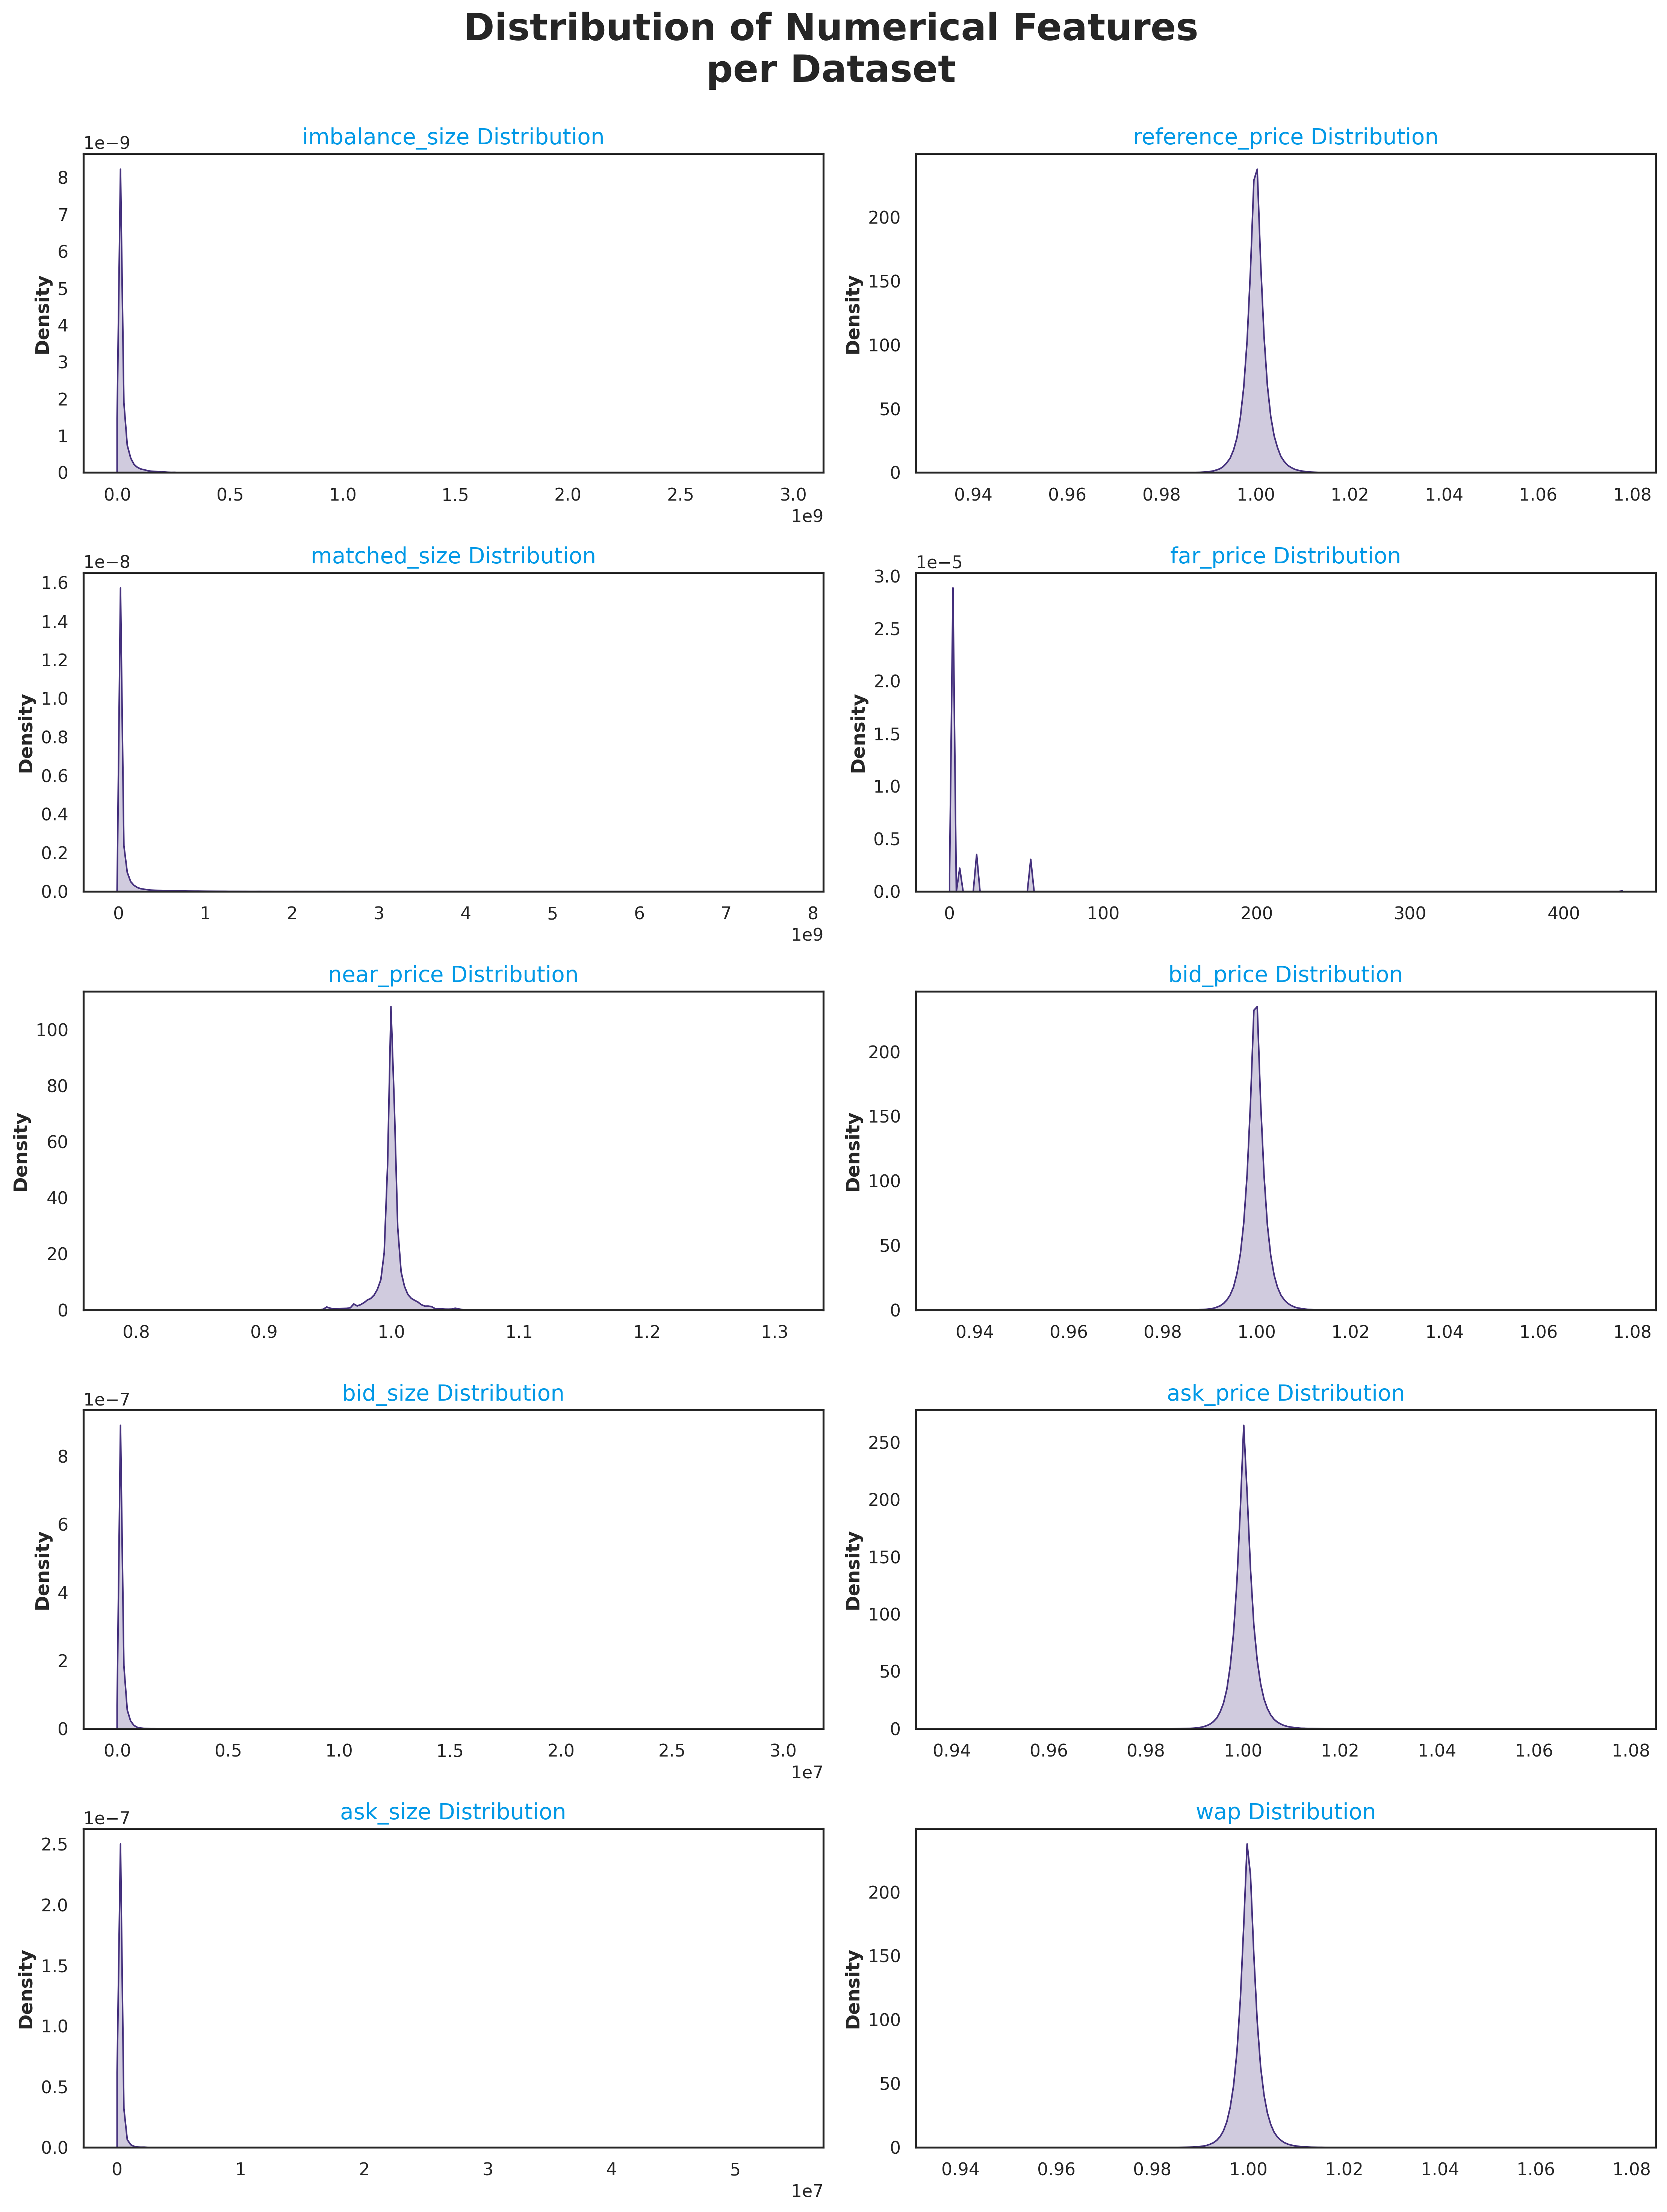

In [44]:
train = pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/train.csv', dtype = dtypes).drop(['row_id', 'time_id'], axis = 1)
temporal_features = ['date_id', 'seconds_in_bucket']
categorical_features = ['imbalance_buy_sell_flag', 'stock_id']
numerical_features = train.drop(temporal_features + categorical_features + ['target'], axis = 1).columns #axis=1 对列操作
fig, ax = plt.subplots(5, 2, figsize = (15, 20), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal[0], fill = True)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Features\nper Dataset\n', fontsize = 24, fontweight = 'bold')
plt.tight_layout()

- ### Categorical Features

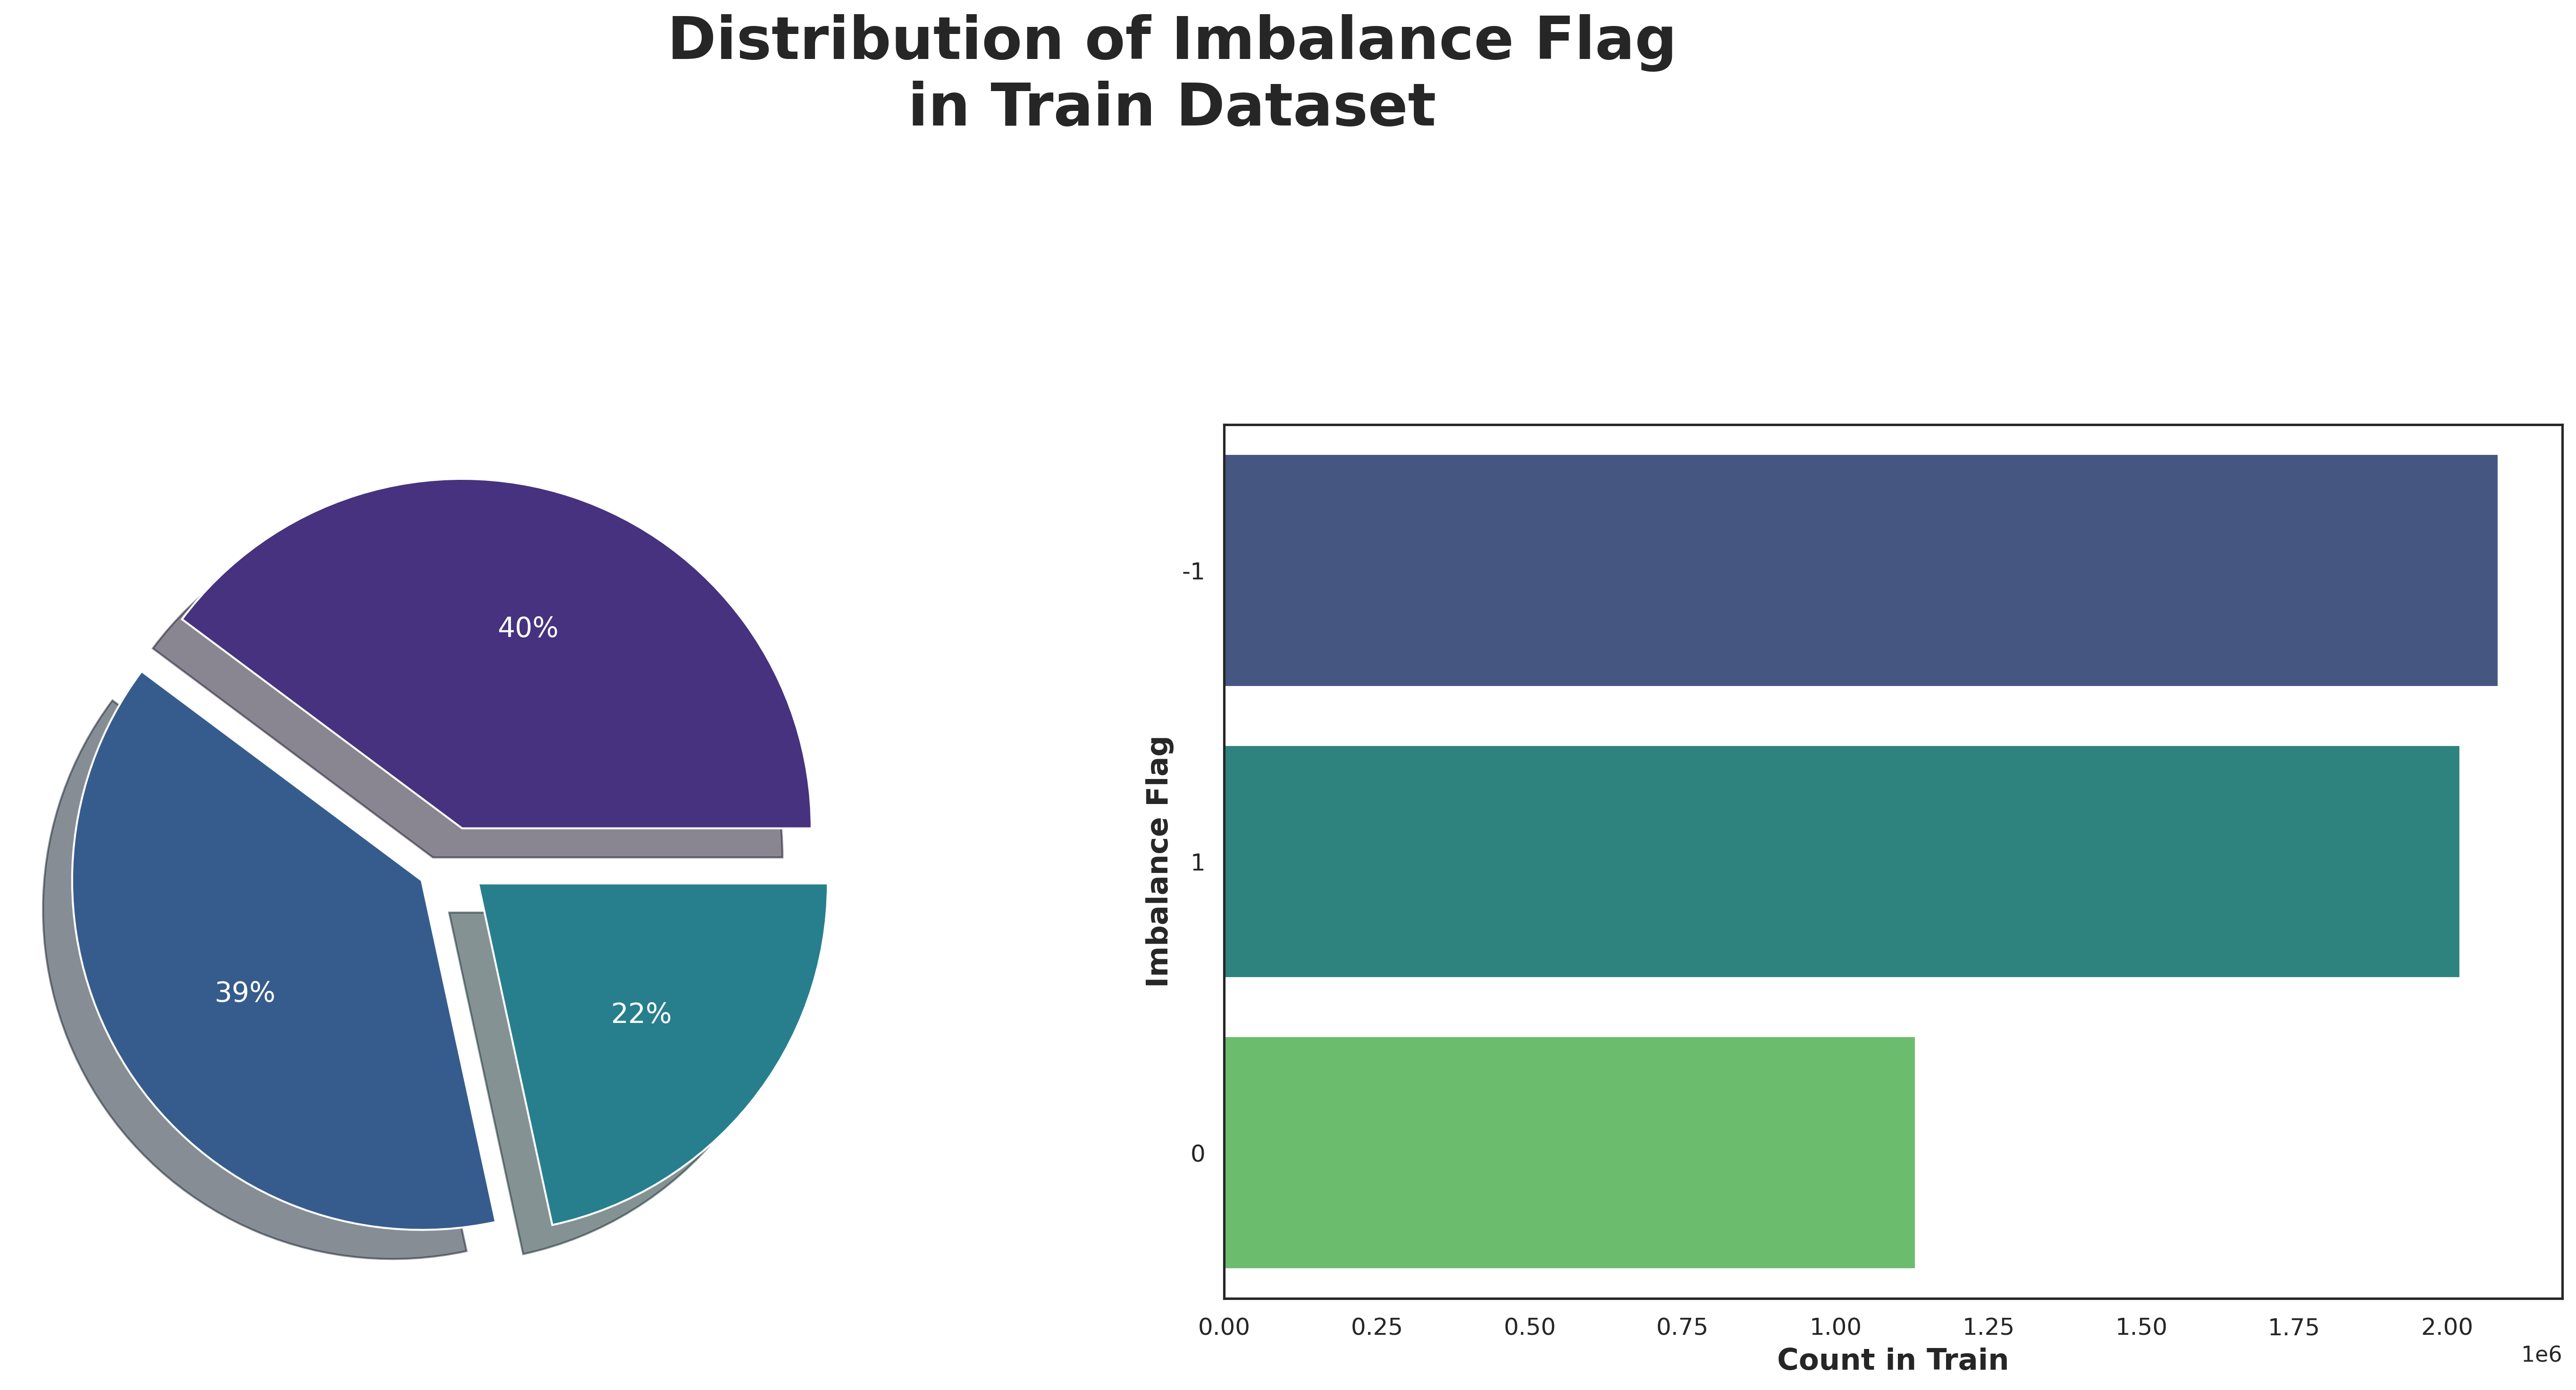

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10), dpi = 300)
ax = ax.flatten()

ax[0].pie(
    train['imbalance_buy_sell_flag'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(train['imbalance_buy_sell_flag'].nunique())], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'imbalance_buy_sell_flag', ax = ax[1], palette = 'viridis', order = train['imbalance_buy_sell_flag'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count in Train', fontsize = 15)
ax[1].set_ylabel('Imbalance Flag', fontsize = 15)
plt.xticks(fontsize = 12)

fig.suptitle('Distribution of Imbalance Flag\nin Train Dataset\n\n\n\n', fontsize = 30, fontweight = 'bold')
plt.tight_layout()

-  **Sell imbalance flag came out the most, followed by buy imbalance flag, with the rarest being the no imbalance flag.**

- ### Target 

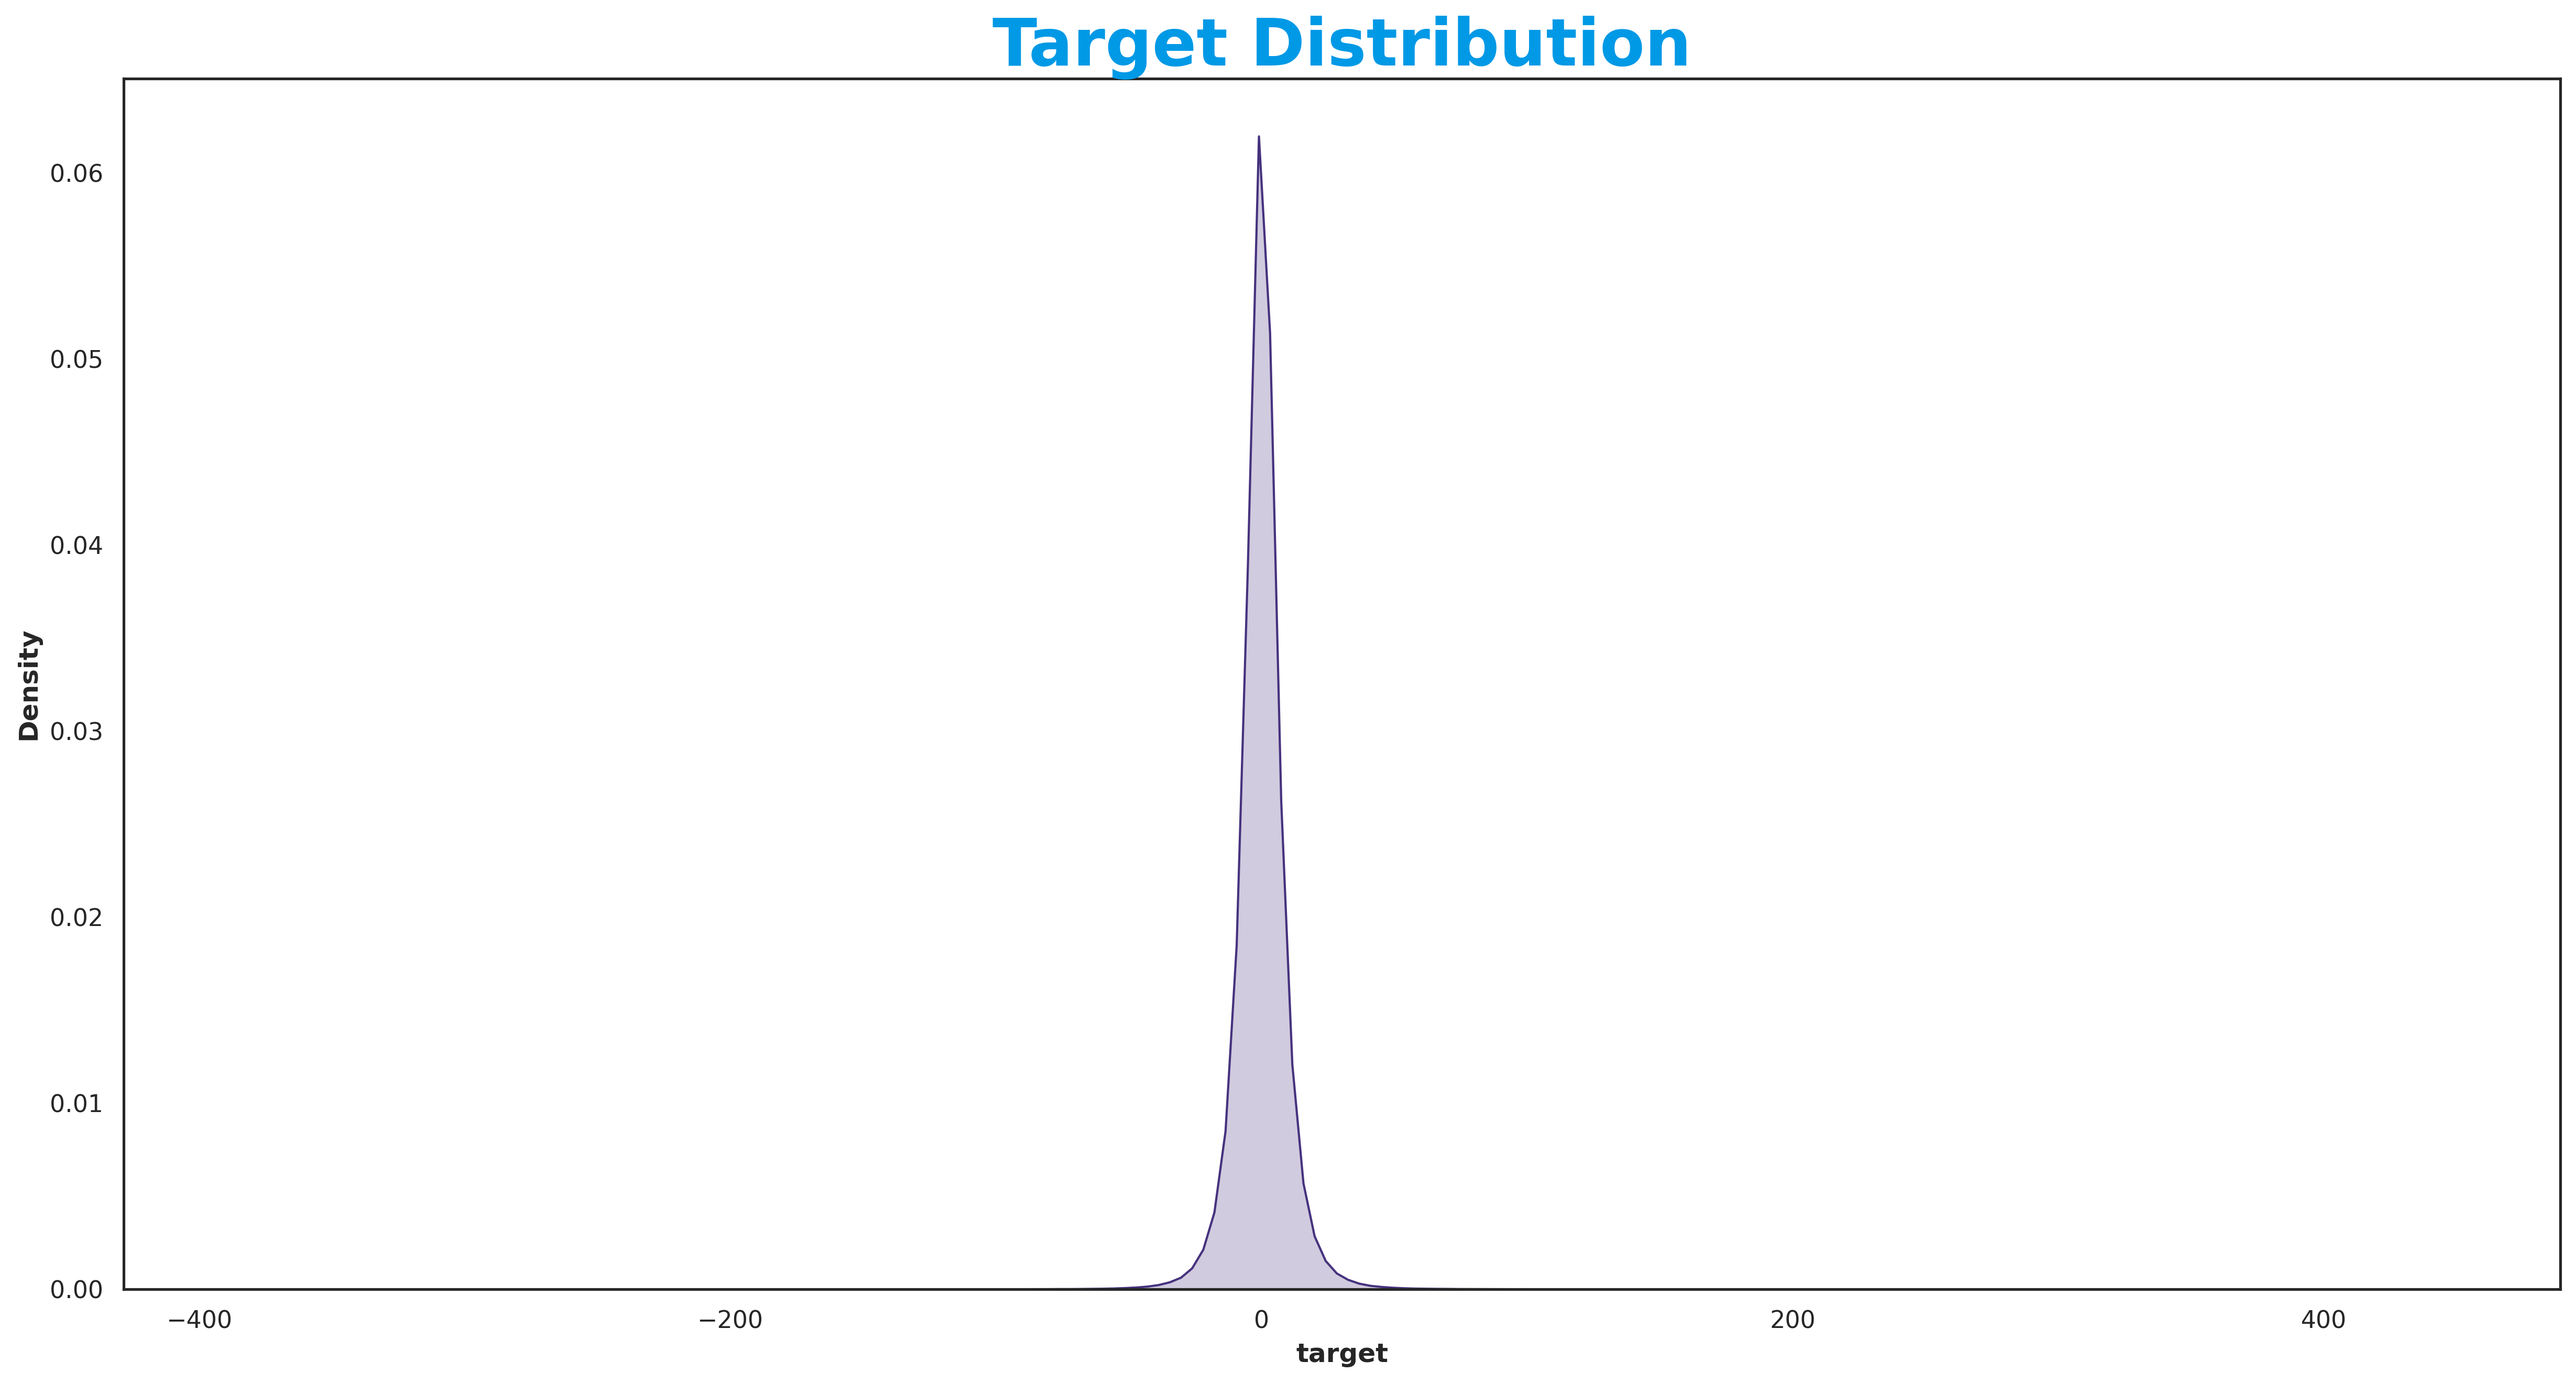

In [46]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.kdeplot(train.target, fill = True)

plt.title('Target Distribution', weight = 'bold', fontsize = 30)
plt.show()

- **Balanced, but High kurtosis. Note that it actually matters in this competition unless you want to use Linear Regression..**

- ### Target over Time

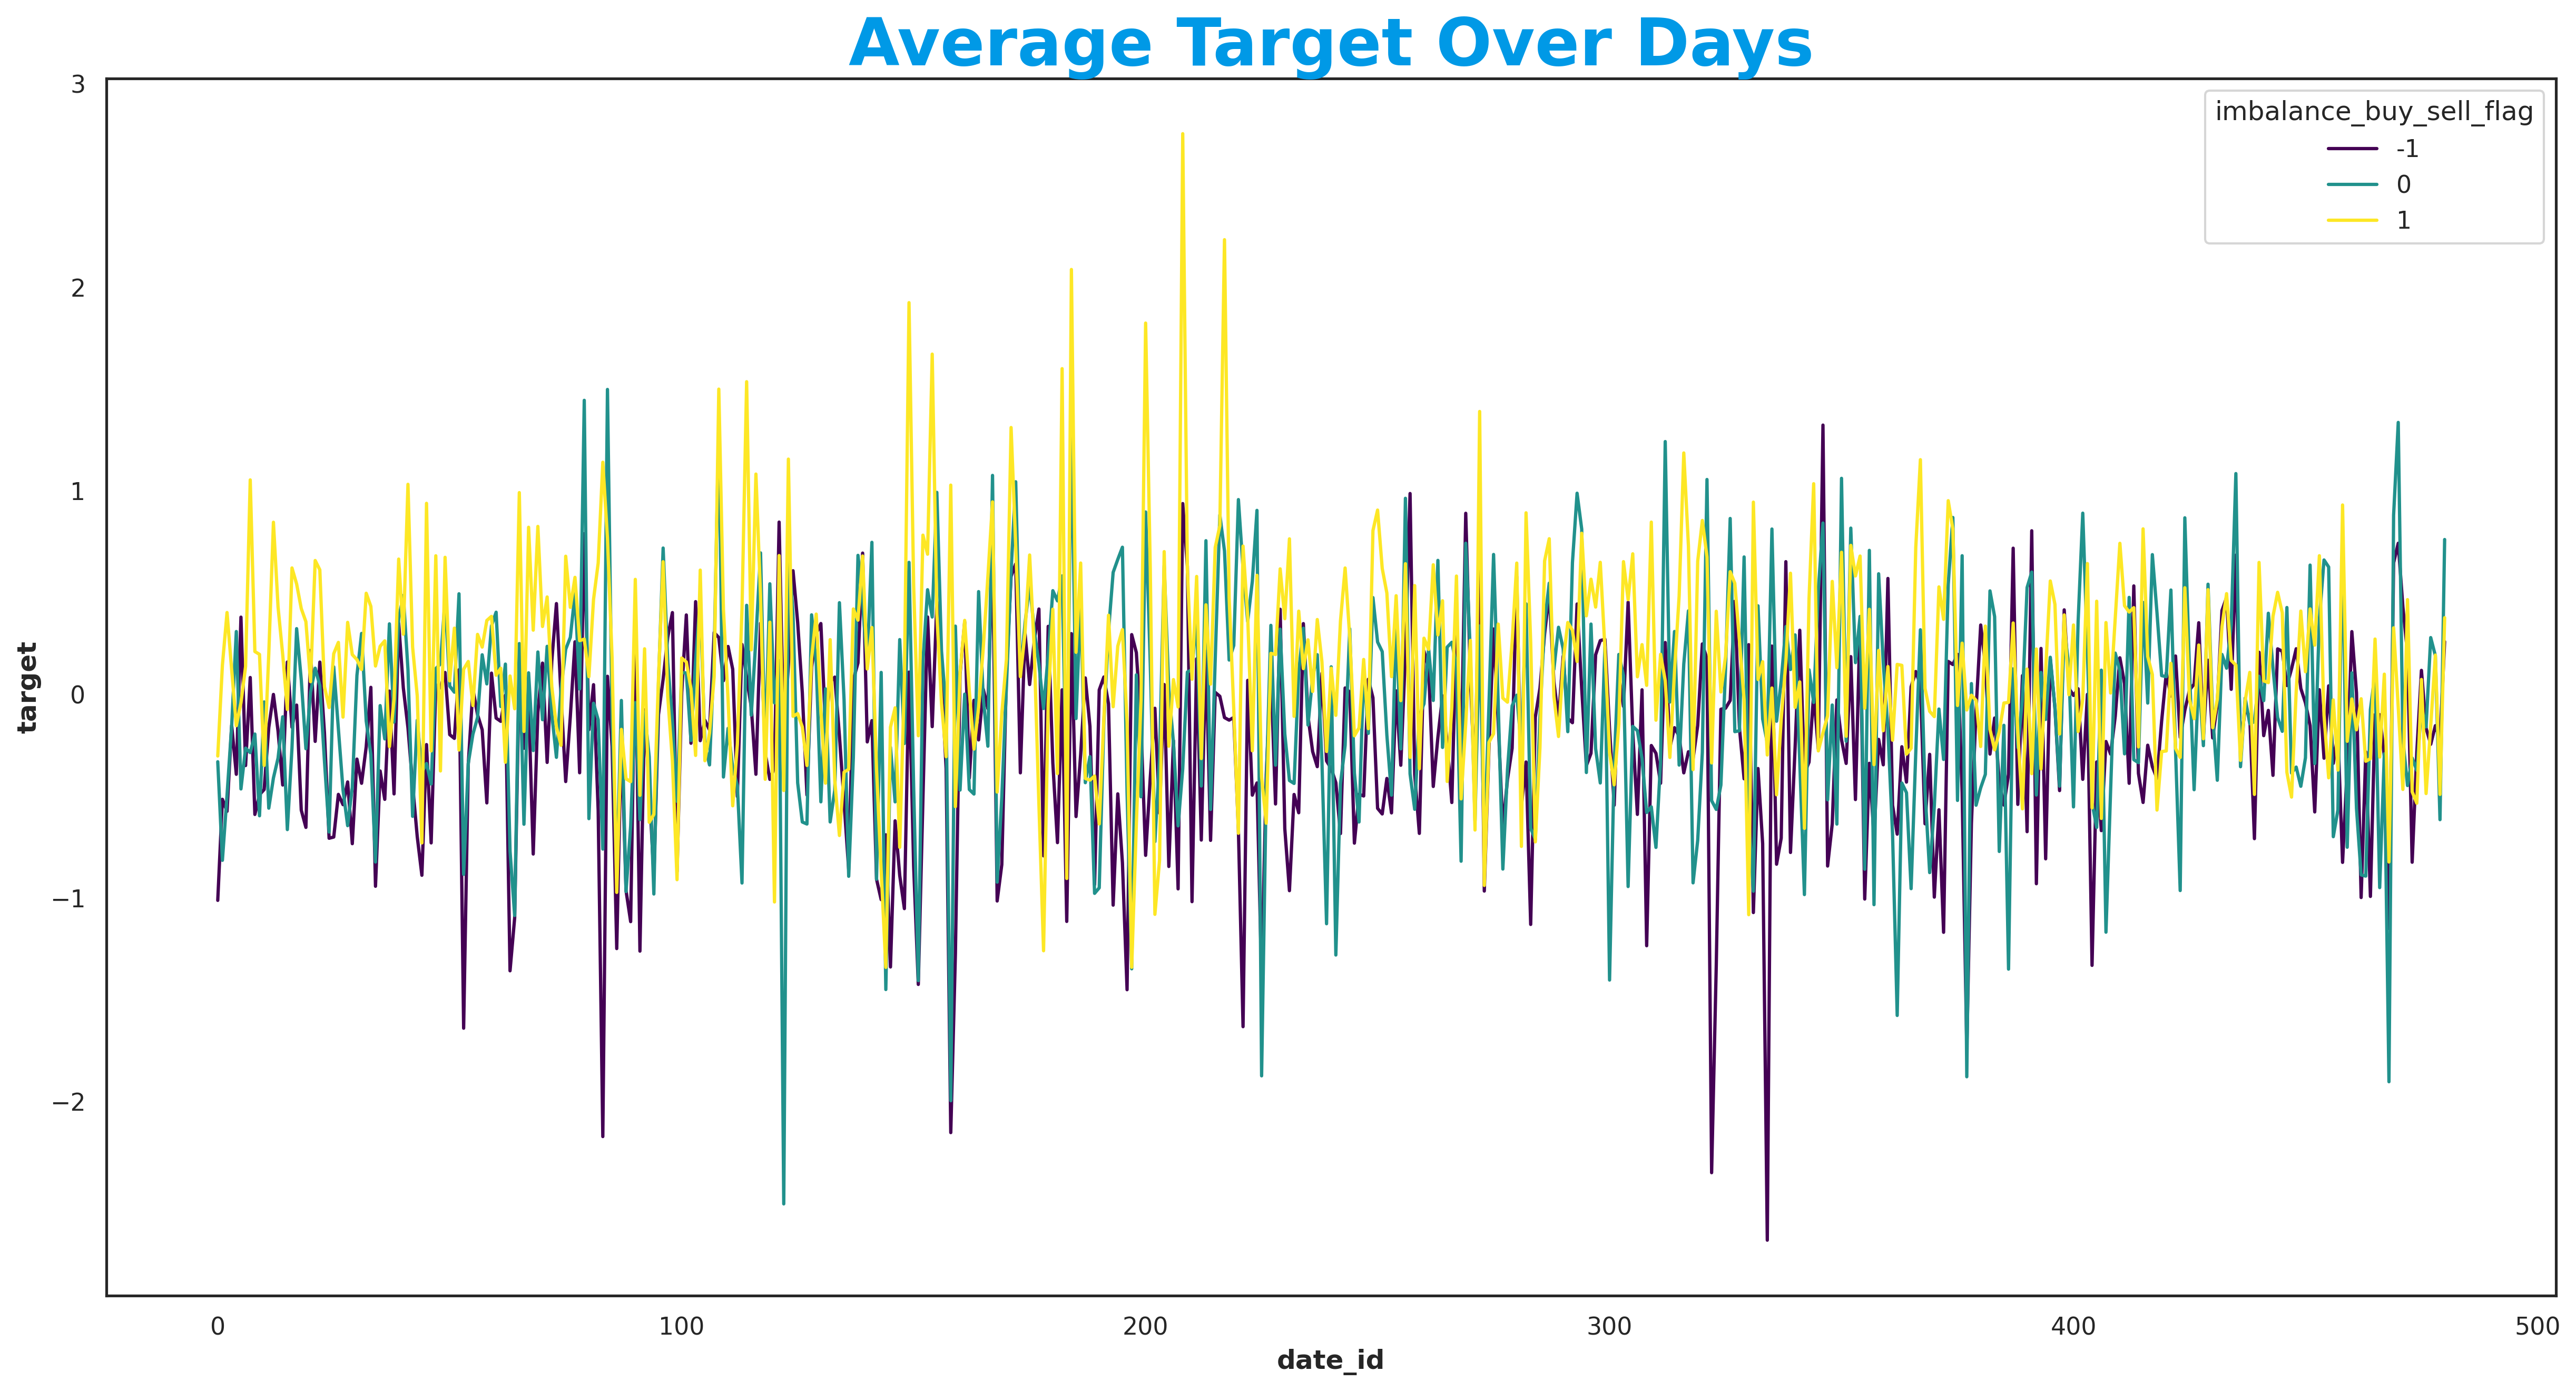

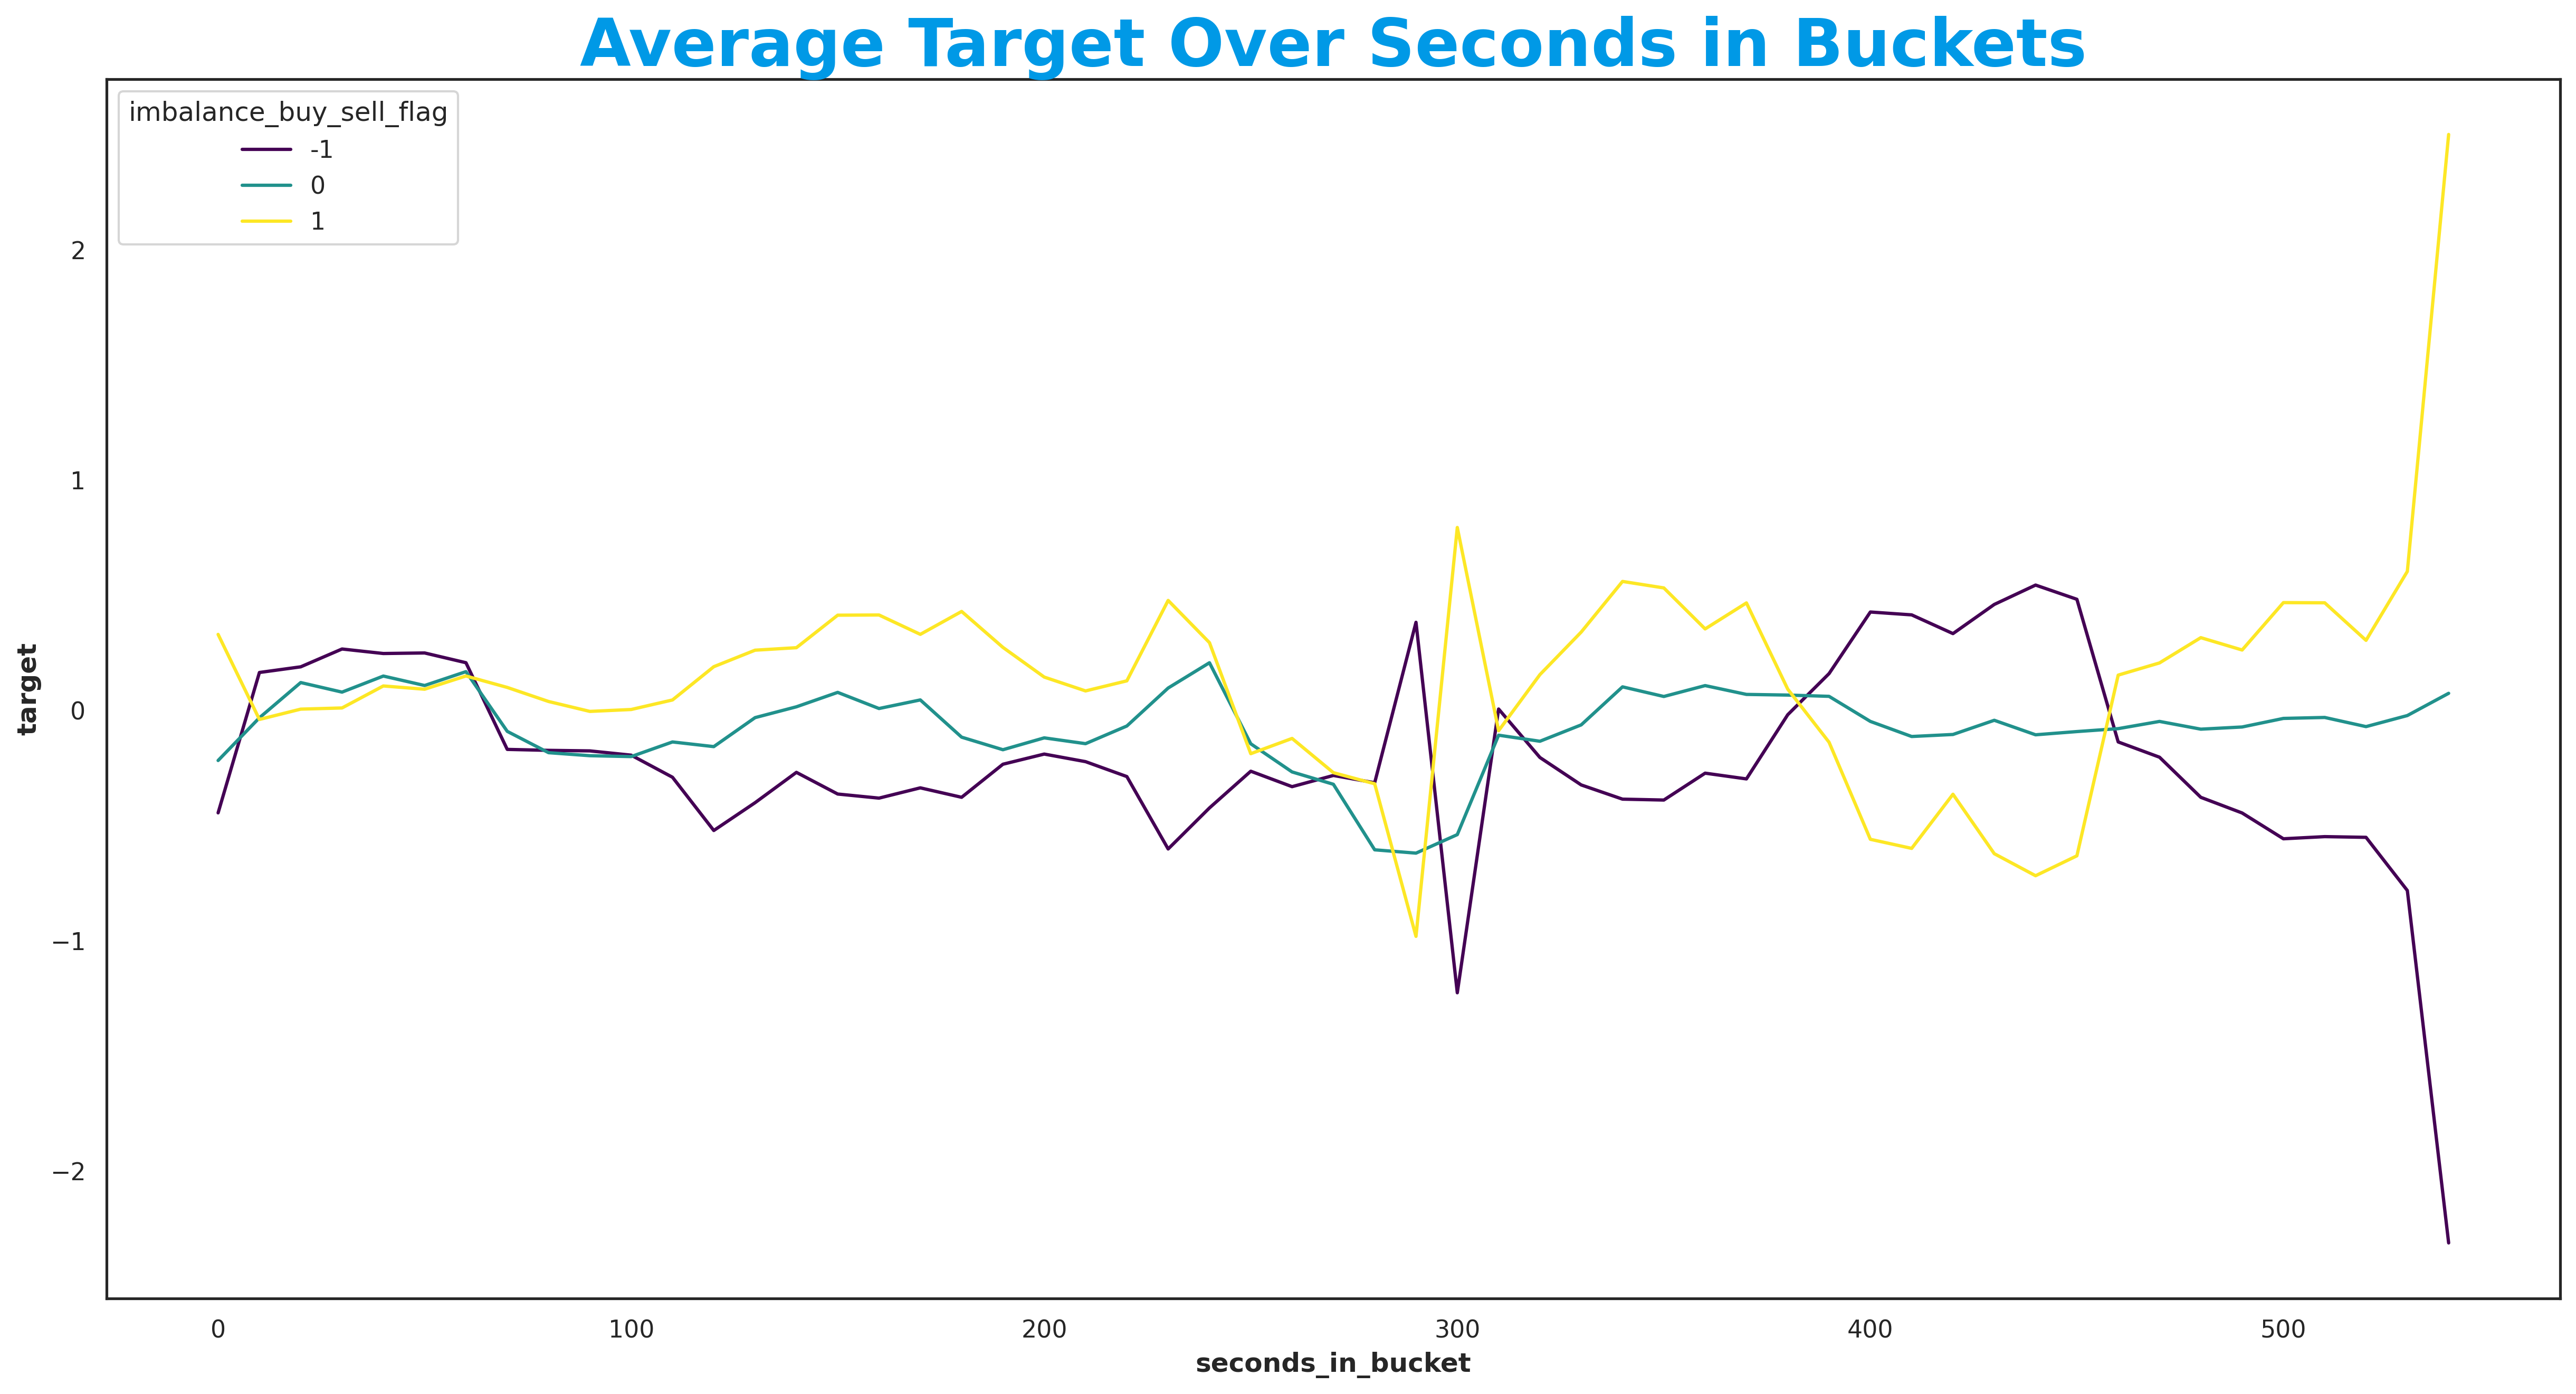

In [47]:
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'date_id', y = 'target', hue = 'imbalance_buy_sell_flag', errorbar = None, palette = 'viridis')

plt.title('Average Target Over Days', weight = 'bold', fontsize = 30)
plt.show()
plt.figure(figsize = (20, 10), dpi = 300)

sns.lineplot(data = train, x = 'seconds_in_bucket', y = 'target', hue = 'imbalance_buy_sell_flag', errorbar = None, palette = 'viridis')

plt.title('Average Target Over Seconds in Buckets', weight = 'bold', fontsize = 30)
plt.show()

- **Stock with buy flag tends to have upspike, while stock with sell flag tend to have downspikes. Actually, no imbalance flag also looks the same as sell flag, except a bit less frequent.**
- **It's obvious that buy and sell stocks go opposite direction, while no imbalance flag tends to stay in the middle. At the end of closing period, we can also see that stock with buy flag goes up while stock with sell flag goes down for the target.**

# ***3. Baseline***

### Steps：
- Data preprocessing： **1. Zero imputation to handle missing values, and standard scaling to normalize the features  2. `Target` dropna**
- Feature Engineering https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/453609

https://www.kaggle.com/competitions/optiver-trading-at-the-close/discussion/451735
- Memory Reduction https://www.kaggle.com/code/ravi20076/optiver-datapreparation

Big dataset--->Covert data format

double a = 1 ----> int a = 1
- Data Partition https://www.kaggle.com/code/lblhandsome/optiver-robust-best-single-model/notebook 交叉划分
> Because this is a time series dataset, we cannot use random KFold to partition the data, which will lead to data leakage (the model will have difficulty converging). Therefore, we strictly ensure that a part of the test set is not used, and divide all training data into (train, valid, test) in time series, valid is used as the basis for train iteration, and the optimal parameters are used on train.

- Model（Cross-validation）

> Honestly, there is only one usable non-neural network model I can think of for this data: LightGBM. First, there are a lot of missing values in the dataset, so we either have to impute them all, or just use model that can take care of it implicitly, which are XGBoost, LightGBM, and CatBoost. Second, due to the size of the dataset, we want to use GPU to increase the speed, and guess what, CatBoost's MAE loss function can't be optimized with GPU. https://www.kaggle.com/code/iqbalsyahakbar/optiver-a-starter-s-notebook

- Evaluation
> MAE


In [4]:
# We split the data here, and use them in the following sections
import pandas as pd
Xy_train = pd.read_csv(DATA_DIR + "train.csv")
X_train = Xy_train.query("target.notna()").drop(['row_id', "time_id"], axis=1)##直接抛弃空值
y_train = X_train.pop("target")

## ***3.1. Naive Baseline***

The following code submit a prediction that all target = 0. 
低于这个 benchmark 说明模型是无效的。

In [9]:
# env = optiver2023.make_env()
# iter_test = env.iter_test()

counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    sample_prediction['target'] = 0
    env.predict(sample_prediction)
    counter += 1

The Naive Forecast submission yields a **score of 5.465** 

As of 2023-09-25, the 1st best score on the Leaderboard is 5.3441 and the 10th best score is 5.3706.

Could the small gap between the score of our Naive Forecast and the Best score on the Leaderboard suggest that **the data are of low predictability?**

## 2.2. Simplest LightGBM Solution

Here, we aim to provide a valid LightGBM solution using as few lines of code as possible.

In [ ]:
# env = optiver2023.make_env()
# iter_test = env.iter_test()

# model = lightgbm.LGBMRegressor(
#     random_state = SEED, 
#     objective = 'mae', 
#     device_type = 'gpu'
# )

# model.fit(X_train, y_train)

# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     sample_prediction['target'] = model.predict(test.drop('row_id', axis = 1))
#     env.predict(sample_prediction)
#     counter += 1

The LightGBM Baseline submission yields a **score of 5.4209** (2023-09-25).

- 5.465 - 5.4209 = 0.0441 (Baseline LightGBM imporved the score from Naive by 0.0441)

- 5.465 - 5.3706 = 0.0944 (10th best score on the Leaderboard imporved the score by 0.0944)

- 5.465 - 5.3441 = 0.1209 (1st best score on the Leaderboard imporved the score by 0.1209)

Still a long way to go...

## 2.3. Improved LightGBM Solution

In [ ]:
# def calculate_imbalance_features(df):
#     # Calculate and add imbalance feature 1 (imb_s1)
#     df['imb_s1'] = df.eval('(bid_size - ask_size) / (bid_size + ask_size)')  

#     # Calculate and add imbalance feature 2 (imb_s2)
#     df['imb_s2'] = df.eval('(imbalance_size - matched_size) / (matched_size + imbalance_size)') 

#     return df

In [ ]:
# estimator = lightgbm.LGBMRegressor(
#     boosting_type='gbdt', 
#     num_leaves=31, 
#     max_depth=-1, 
#     learning_rate=0.1, 
#     n_estimators=100, 
#     subsample_for_bin=200000, 
#     objective='mae', 
#     class_weight=None, 
#     min_split_gain=0.0, 
#     min_child_weight=0.001, 
#     min_child_samples=20, 
#     subsample=1.0, 
#     subsample_freq=0, 
#     colsample_bytree=1.0, 
#     reg_alpha=0.0, 
#     reg_lambda=0.0, 
#     random_state=SEED, 
#     n_jobs=-1, 
#     importance_type='split',
#     force_row_wise=True
# )

# val_predictions = np.zeros(len(X_train))
# val_scores = []

# splitter = sk.model_selection.TimeSeriesSplit(5).split(X_train, y_train)

# for fold, (train_idx, val_idx) in enumerate(splitter):
#     model = sk.base.clone(estimator)

#     # Define train and val set
#     X_train = X_train.iloc[train_idx]
#     y_train = y_train.iloc[train_idx]
#     X_val = X_train.iloc[val_idx]
#     y_val = y_train.iloc[val_idx]

#     model.fit(X_train, y_train)
#     val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val), y_val))

# print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

In [ ]:
# import optiver2023

# env = optiver2023.make_env()
# iter_test = env.iter_test()

# model.fit(X_train, y_train)

# counter = 0
# for (test, revealed_targets, sample_prediction) in iter_test:
#     sample_prediction['target'] = model.predict(test.drop('row_id', axis = 1))
#     env.predict(sample_prediction)
#     counter += 1

# 3. Final Thoughts

In [ ]:
END = pd.Timestamp.now()
time_elapsed = (END - START).total_seconds()
print(f"Notebook Total Time: {time_elapsed:.2f}s")